# AD699 Semester Project: Zurich Airbnb Data Analysis
## Team: Group 5
## Members: Yixuan Yang, Gavin Boss, Eva Sanchez, Saurabh Sharma


---

## Project Overview
This project analyzes Airbnb rental data from Zurich, Switzerland to uncover patterns in pricing, amenities, host behavior, and geographic clustering. We employ various data mining techniques including regression, classification (k-NN, decision trees, transformers), and clustering to extract insights from real-world rental data.

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# For text processing and word clouds
from wordcloud import WordCloud
import re
import os
# For mapping
import folium
from folium.plugins import HeatMap

# For machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, mean_absolute_error
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# For transformers (we'll use a simple approach with sentence transformers)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
print(f"  pandas version: {pd.__version__}")
print(f"  numpy version: {np.__version__}")

  pandas version: 2.3.3
  numpy version: 2.3.5


In [3]:
output_dir = 'output'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created '{output_dir}' directory")
else:
    print(f"'{output_dir}' directory already exists")

Created 'output' directory


---
# Part 1: Data Preparation & Exploration

## 1.1 Loading the Data

In [4]:
# Load the Zurich Airbnb dataset
df = pd.read_csv('data/zurich_listings.csv')

rows, columns = df.shape
# Display basic information about the dataset
print(f"Dataset Shape: {rows} rows × {columns} columns")
print("\nColumn Names:")
#print(df.columns.tolist())

Dataset Shape: 2534 rows × 75 columns

Column Names:


## 1.2 Missing Values Analysis and Treatment

### Understanding the Missing Data

Columns with missing values: 26



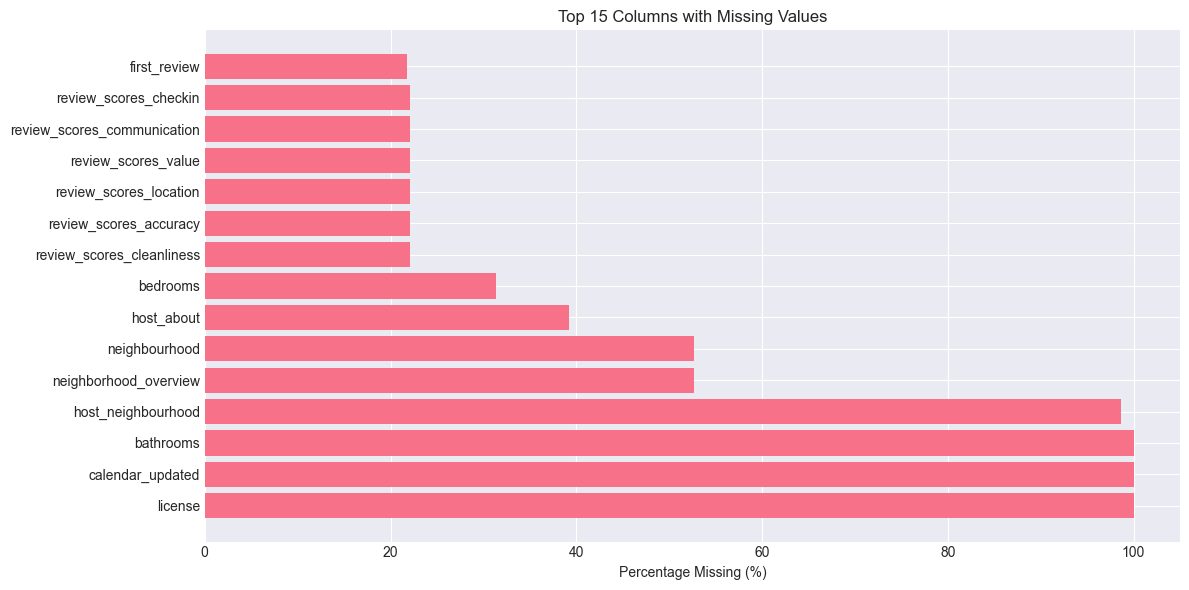

In [5]:
# Calculate missing values for each column
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
}).sort_values('Missing_Percentage', ascending=False)

# Show only columns with missing values
missing_data_filtered = missing_data[missing_data['Missing_Count'] > 0]
print(f"Columns with missing values: {len(missing_data_filtered)}\n")
#print(missing_data_filtered.head(20))

# Visualize missing data patterns
plt.figure(figsize=(12, 6))
top_missing = missing_data_filtered.head(15)
plt.barh(top_missing['Column'], top_missing['Missing_Percentage'])
plt.xlabel('Percentage Missing (%)')
plt.title('Top 15 Columns with Missing Values')
plt.tight_layout()
plt.savefig('output/missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Missing Values Treatment Strategy

**Our Approach to Handling Missing Values:**

After analyzing the missing data patterns in our Zurich Airbnb dataset, we developed a strategic approach to handle missing values based on the nature of each variable and its importance for our analyses:

**1. Text Fields (`description`, `neighborhood_overview`, `host_about`):** For text columns with missing values, we replace NaN with empty strings. This is crucial for our transformer model in the classification section, as missing text data __doesn't necessarily indicate lack of information—some hosts simply don't provide certain descriptions__. By converting to empty strings, we can still process these records through text analysis without losing valuable data points.

**2. Review Scores and Metrics:** Columns like `review_scores_rating`, `review_scores_cleanliness`, and `reviews_per_month` have missing values primarily because some listings haven't received reviews yet. For regression analysis, we'll either exclude these rows or use median imputation depending on the specific model. For listings without reviews, this is legitimate missing data rather than a data quality issue—new listings naturally lack review history.

**3. Numerical Features (`bedrooms`, `beds`):** We use __median imputation__ for missing numerical features. The median is more robust to outliers than the mean, which is important for rental data where luxury properties can skew averages. For example, if bedrooms are missing, we impute the median number of bedrooms for similar property types.

**4. Bathrooms Handling:** The original `bathrooms` column is 100% missing (Airbnb deprecated this numeric field). However, the `bathrooms_text` column contains descriptive information like "1.5 baths" or "2 shared baths". We extract the numeric value using regex pattern matching, then apply median imputation to any remaining missing values. This creates a clean `bathrooms_clean` variable suitable for quantitative analysis.

**5. Price Variable:** Since `price` is our key outcome variable for regression, we'll remove any rows where price is missing. These represent only a small fraction of our data, and imputing the target variable would compromise our model's integrity. This ensures our predictions are based on actual market prices.

**6. Host Response Information:** For `host_response_time` and `host_response_rate`, missing values often indicate hosts who haven't yet established a response pattern. We'll handle these carefully in our classification tree analysis, potentially creating a separate "Unknown" category to preserve these data points.

This multi-faceted approach balances data retention with analytical validity. We avoid simply dropping all rows with any missing values (which would eliminate over 50% of our dataset) while ensuring that our imputation methods don't introduce bias into our models. Different analyses may warrant different treatments, and we'll adapt our strategy as needed for each section of the project.

In [6]:
# Create a working copy of the dataframe
df_clean = df.copy()

# 1. Handle price column - convert from string to numeric
# Price is stored as '$XXX.XX' format, need to clean it
def clean_price(price):
    """Convert price from string format to numeric"""
    if pd.isna(price):
        return np.nan
    # Remove '$' and ',' from price string
    return float(str(price).replace('$', '').replace(',', ''))

df_clean['price'] = df_clean['price'].apply(clean_price)

In [7]:

# 2. Handle bathrooms_text column - extract numeric bathroom count
def extract_bathrooms(bath_text):
    """
    Extract numeric bathroom count from descriptive text.
    E.g: '1.5 baths' → 1.5, '2 shared baths' → 2.0
    """
    if pd.isna(bath_text) or bath_text == '':
        return np.nan
    # Use regex to find first number
    match = re.search(r'(\d+\.?\d*)', str(bath_text))
    if match:
        return float(match.group(1))
    return np.nan

df_clean['bathrooms_clean'] = df_clean['bathrooms_text'].apply(extract_bathrooms)
bathrooms_median = df_clean['bathrooms_clean'].median()
df_clean['bathrooms_clean'] = df_clean['bathrooms_clean'].fillna(bathrooms_median)
print(f"Extracted and filled bathrooms. Median: {bathrooms_median}")


Extracted and filled bathrooms. Median: 1.0


In [8]:

# 3. Fill text columns with empty strings
text_columns = ['description', 'neighborhood_overview', 'host_about', 'name']
for col in text_columns:
    df_clean[col] = df_clean[col].fillna('')



In [9]:
# 4. Handle numerical features with median imputation
numeric_features = ['bedrooms', 'beds']  # bathrooms handled separately above
for col in numeric_features:
    if col in df_clean.columns:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f"Filled {col} missing values with median: {median_val}")


Filled bedrooms missing values with median: 1.0
Filled beds missing values with median: 1.0


In [10]:

# 5. Handle host_response_time - create 'unknown' category
if 'host_response_time' in df_clean.columns:
    df_clean['host_response_time'] = df_clean['host_response_time'].fillna('unknown')

# 6. Fill review scores with median (alternative: could drop these rows for specific analyses)
review_columns = ['review_scores_rating', 
                  'review_scores_accuracy', 
                  'review_scores_cleanliness', 
                  'review_scores_checkin',
                  'review_scores_communication', 
                  'review_scores_location', 
                  'review_scores_value']


In [11]:
for col in review_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 7. Fill reviews_per_month with 0 (no reviews means 0 reviews per month)
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)

print("\nMissing Values After Treatment")

print(f"Rows remaining: {len(df_clean)}")
print(f"\nColumns with missing values: {df_clean.isnull().sum().sum()}")
print("\nTop columns still with missing values:")
still_missing = df_clean.isnull().sum().sort_values(ascending=False).head(10)
print(still_missing[still_missing > 0])


Missing Values After Treatment
Rows remaining: 2534

Columns with missing values: 13917

Top columns still with missing values:
calendar_updated        2534
license                 2534
bathrooms               2534
host_neighbourhood      2499
neighbourhood           1334
last_review              553
first_review             553
host_response_rate       526
host_location            442
host_acceptance_rate     364
dtype: int64


## 1.3 Summary Statistics by Neighborhood

### Exploring Geographic Variations in Zurich Rentals

In [12]:
# First, let's see what neighborhoods we have
print("Number of unique neighborhoods:", df_clean['neighbourhood_cleansed'].nunique())
print("\nTop 10 neighborhoods by listing count:")
neighborhood_counts = df_clean['neighbourhood_cleansed'].value_counts().head(10)
print(neighborhood_counts)

# Focus on top 10 neighborhoods for clearer analysis
top_neighborhoods = neighborhood_counts.index.tolist()
df_top_neighborhoods = df_clean[df_clean['neighbourhood_cleansed'].isin(top_neighborhoods)]

print(f"\nAnalyzing {len(df_top_neighborhoods)} listings across {len(top_neighborhoods)} neighborhoods")

Number of unique neighborhoods: 34

Top 10 neighborhoods by listing count:
neighbourhood_cleansed
Langstrasse     189
Sihlfeld        167
Altstetten      166
Oerlikon        134
Rathaus         129
Alt-Wiedikon    127
Unterstrass     118
Enge             93
Seefeld          93
Wollishofen      92
Name: count, dtype: int64

Analyzing 1308 listings across 10 neighborhoods


In [13]:
# Summary Statistic 1: Average Price by Neighborhood
print("SUMMARY STATISTIC 1: Average Price by Neighborhood")

price_by_neighborhood = df_top_neighborhoods.groupby('neighbourhood_cleansed')['price'].agg([
    ('Mean Price (CHF)', 'mean'),
    ('Median Price (CHF)', 'median'),
    ('Std Dev', 'std'),
    ('Count', 'count')
]).round(2).sort_values('Mean Price (CHF)', ascending=False)

print(price_by_neighborhood)

print("\nTakeaway: This shows which neighborhoods command premium prices. ")
print("High standard deviation indicates diverse property types within a neighborhood.")

SUMMARY STATISTIC 1: Average Price by Neighborhood
                        Mean Price (CHF)  Median Price (CHF)  Std Dev  Count
neighbourhood_cleansed                                                      
Rathaus                           267.86               150.0   262.15    129
Enge                              260.10               129.0  1007.73     93
Altstetten                        235.54               135.5   206.37    166
Seefeld                           234.69               163.0   264.78     93
Langstrasse                       190.87               144.0   152.37    189
Oerlikon                          187.76               130.0   161.07    134
Unterstrass                       182.39               137.5   214.29    118
Wollishofen                       170.37               140.0   169.05     92
Alt-Wiedikon                      154.72               119.0   143.24    127
Sihlfeld                          139.58               116.0    99.63    167

Takeaway: This shows whi

In [14]:
# Summary Statistic 2: Property Type Distribution by Neighborhood
print("SUMMARY STATISTIC 2: Room Type Distribution by Neighborhood")


room_type_dist = pd.crosstab(
    df_top_neighborhoods['neighbourhood_cleansed'], 
    df_top_neighborhoods['room_type'], 
    normalize='index'
) * 100

print(room_type_dist.round(2))

print("\nTakeaway: This reveals whether neighborhoods cater to different traveler types.")

# TBD add more details?
# Kind of straight forward deduction
print("High 'Entire home/apt' % suggests family-oriented areas; high 'Private room' suggests budget options.")

SUMMARY STATISTIC 2: Room Type Distribution by Neighborhood
room_type               Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_cleansed                                                        
Alt-Wiedikon                      77.95        0.00         22.05         0.00
Altstetten                        62.05        0.60         36.75         0.60
Enge                              67.74        0.00         32.26         0.00
Langstrasse                       73.02        0.53         25.40         1.06
Oerlikon                          67.91        0.00         32.09         0.00
Rathaus                           74.42        1.55         22.48         1.55
Seefeld                           86.02        0.00         13.98         0.00
Sihlfeld                          80.84        0.00         19.16         0.00
Unterstrass                       75.42        0.00         22.88         1.69
Wollishofen                       68.48        0.00         23.91      

In [15]:
# Summary Statistic 3: Average Review Scores by Neighborhood
print("SUMMARY STATISTIC 3: Average Review Scores by Neighborhood")

review_by_neighborhood = df_top_neighborhoods.groupby('neighbourhood_cleansed').agg({
    'review_scores_rating': 'mean',
    'review_scores_location': 'mean',
    'review_scores_value': 'mean',
    'number_of_reviews': 'mean'
}).round(2).sort_values('review_scores_rating', ascending=False)

review_by_neighborhood.columns = ['Overall Rating', 'Location Score', 'Value Score', 'Avg # Reviews']
print(review_by_neighborhood)

print("\nTakeaway: Higher location scores indicate desirable areas for tourists.")
print("Discrepancies between overall rating and value suggest price sensitivity.")

SUMMARY STATISTIC 3: Average Review Scores by Neighborhood
                        Overall Rating  Location Score  Value Score  \
neighbourhood_cleansed                                                
Unterstrass                       4.84            4.87         4.73   
Wollishofen                       4.83            4.81         4.70   
Langstrasse                       4.78            4.80         4.66   
Enge                              4.77            4.86         4.65   
Oerlikon                          4.77            4.75         4.61   
Seefeld                           4.76            4.90         4.68   
Sihlfeld                          4.74            4.83         4.62   
Altstetten                        4.73            4.69         4.61   
Alt-Wiedikon                      4.72            4.77         4.65   
Rathaus                           4.61            4.88         4.50   

                        Avg # Reviews  
neighbourhood_cleansed                 
Unterstr

In [16]:
# Summary Statistic 4: Accommodation Capacity by Neighborhood
print("SUMMARY STATISTIC 4: Property Size Metrics by Neighborhood")

capacity_by_neighborhood = df_top_neighborhoods.groupby('neighbourhood_cleansed').agg({
    'accommodates': 'mean',
    'bedrooms': 'mean',
    'beds': 'mean',
    'bathrooms_clean': 'mean'
}).round(2).sort_values('accommodates', ascending=False)

capacity_by_neighborhood.columns = ['Avg Guests', 'Avg Bedrooms', 'Avg Beds', 'Avg Bathrooms']

print(capacity_by_neighborhood)

print("\nTakeaway: Neighborhoods with larger properties may cater to families or groups.")
print("This metric helps understand the target demographic for each area.")

SUMMARY STATISTIC 4: Property Size Metrics by Neighborhood
                        Avg Guests  Avg Bedrooms  Avg Beds  Avg Bathrooms
neighbourhood_cleansed                                                   
Wollishofen                   3.04          1.30      1.90           1.27
Enge                          2.97          1.28      1.74           1.30
Oerlikon                      2.93          1.32      1.77           1.14
Unterstrass                   2.91          1.38      1.62           1.17
Seefeld                       2.84          1.19      1.54           1.13
Alt-Wiedikon                  2.82          1.31      1.69           1.16
Rathaus                       2.74          1.18      1.49           1.13
Langstrasse                   2.68          1.52      1.63           1.12
Altstetten                    2.55          1.16      1.45           1.10
Sihlfeld                      2.53          1.21      1.37           1.10

Takeaway: Neighborhoods with larger properties may c

In [17]:
# Summary Statistic 5: Host Response Metrics by Neighborhood
print("SUMMARY STATISTIC 5: Host Professionalism by Neighborhood")

# Clean host_response_rate (convert percentage string to float)
def clean_percentage(val):
    if pd.isna(val):
        return np.nan
    return float(str(val).replace('%', ''))

df_top_neighborhoods['host_response_rate_clean'] = df_top_neighborhoods['host_response_rate'].apply(clean_percentage)

host_metrics = df_top_neighborhoods.groupby('neighbourhood_cleansed').agg({
    'host_response_rate_clean': 'mean',
    'host_is_superhost': lambda x: (x == 't').sum() / len(x) * 100,
    'instant_bookable': lambda x: (x == 't').sum() / len(x) * 100,
    'host_total_listings_count': 'mean'
}).round(2).sort_values('host_response_rate_clean', ascending=False)

host_metrics.columns = ['Response Rate %', 'Superhost %', 'Instant Book %', 'Avg Listings per Host']

print(host_metrics)

print("\nTakeaway: High superhost % and response rates indicate professional hosting culture.")
print("Multiple listings per host may indicate commercial operations vs. individual hosts.")

SUMMARY STATISTIC 5: Host Professionalism by Neighborhood
                        Response Rate %  Superhost %  Instant Book %  \
neighbourhood_cleansed                                                 
Rathaus                           98.03        26.36           41.09   
Alt-Wiedikon                      94.26        13.39           26.77   
Wollishofen                       93.87        15.22           17.39   
Altstetten                        93.84        16.87           44.58   
Unterstrass                       92.86        30.51           19.49   
Seefeld                           91.90        25.81           25.81   
Enge                              91.68        22.58           17.20   
Oerlikon                          91.59        18.66           25.37   
Sihlfeld                          91.42        15.57           23.35   
Langstrasse                       89.46        16.40           25.40   

                        Avg Listings per Host  
neighbourhood_cleansed       

### Summary Statistics Findings

Our analysis of Zurich's top __neighborhoods__ reveals distinct patterns in the short-term rental market:

**Pricing Patterns:** The neighborhoods show considerable variation in average prices, reflecting Zurich's diverse urban geography. Central districts and areas near major attractions command premium prices, while peripheral neighborhoods offer more budget-friendly options. The standard deviation in prices within neighborhoods indicates that even "expensive" areas have affordable options, likely reflecting the mix of property types (entire apartments vs. private rooms).

**Property Type Distribution:** The room type distribution shows which neighborhoods cater to different traveler segments. Areas with high percentages of entire homes/apartments typically serve families and longer-term visitors, while neighborhoods dominated by private rooms attract budget-conscious solo travelers and backpackers. This segmentation helps property owners understand their competition and helps travelers find suitable neighborhoods.

**Guest Experience:** Review scores provide insight into guest satisfaction across neighborhoods. Interestingly, location scores often vary independently from overall ratings, suggesting that some areas sacrifice convenience for value or space. The average number of reviews per neighborhood indicates booking velocity—neighborhoods with higher review counts see more turnover, suggesting either high demand or shorter average stays.

**Property Characteristics:** The accommodation capacity metrics reveal the typical property profile in each neighborhood. Areas with higher average guest capacity and bedroom counts likely contain more family-oriented rentals, while lower capacity suggests studio apartments and rooms for business travelers. This information is valuable for understanding inventory composition.

**Host Professionalism:** The host metrics illuminate the operational character of each neighborhood's rental market. Areas with high superhost percentages and response rates indicate a mature, professional hosting ecosystem. Higher listings-per-host averages suggest the presence of property management companies or commercial operators, while lower numbers indicate more individual, owner-occupied rentals. This distinction affects guest experience and market dynamics—commercial operations may offer more consistency but less personal touches.

## 1.4 Data Visualizations

### Five Different Visualization Types to Understand Zurich's Rental Market

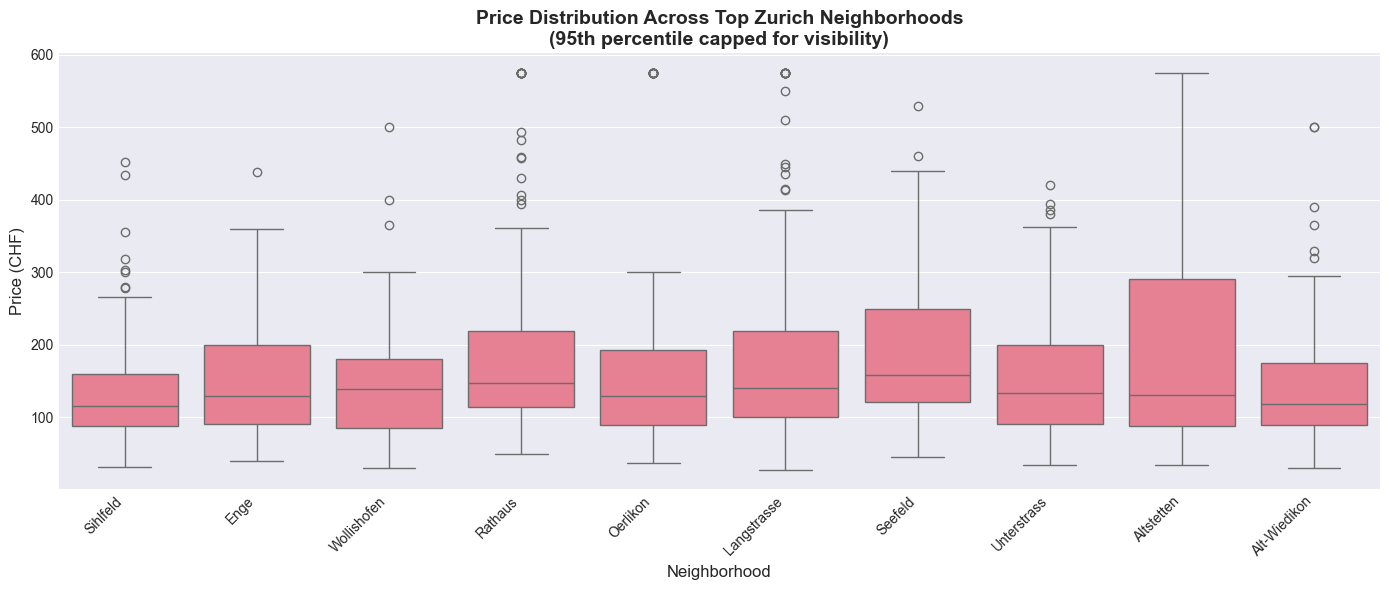

This box plot reveals price ranges and outliers in each neighborhood.
Wide boxes indicate diverse price points; narrow boxes suggest homogeneous pricing.


In [18]:
# Visualization 1: Box Plot - Price Distribution Across Top Neighborhoods
plt.figure(figsize=(14, 6))
# Filter extreme outliers for better visualization
price_data = df_top_neighborhoods[df_top_neighborhoods['price'] <= df_top_neighborhoods['price'].quantile(0.95)]

sns.boxplot(data=price_data, x='neighbourhood_cleansed', y='price')
plt.xticks(rotation=45, ha='right')
plt.title('Price Distribution Across Top Zurich Neighborhoods\n(95th percentile capped for visibility)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Price (CHF)', fontsize=12)
plt.tight_layout()
plt.savefig('output/price_distribution_neighborhoods.png', dpi=300, bbox_inches='tight')
plt.show()

print("This box plot reveals price ranges and outliers in each neighborhood.")
print("Wide boxes indicate diverse price points; narrow boxes suggest homogeneous pricing.")

<Figure size 1400x600 with 0 Axes>

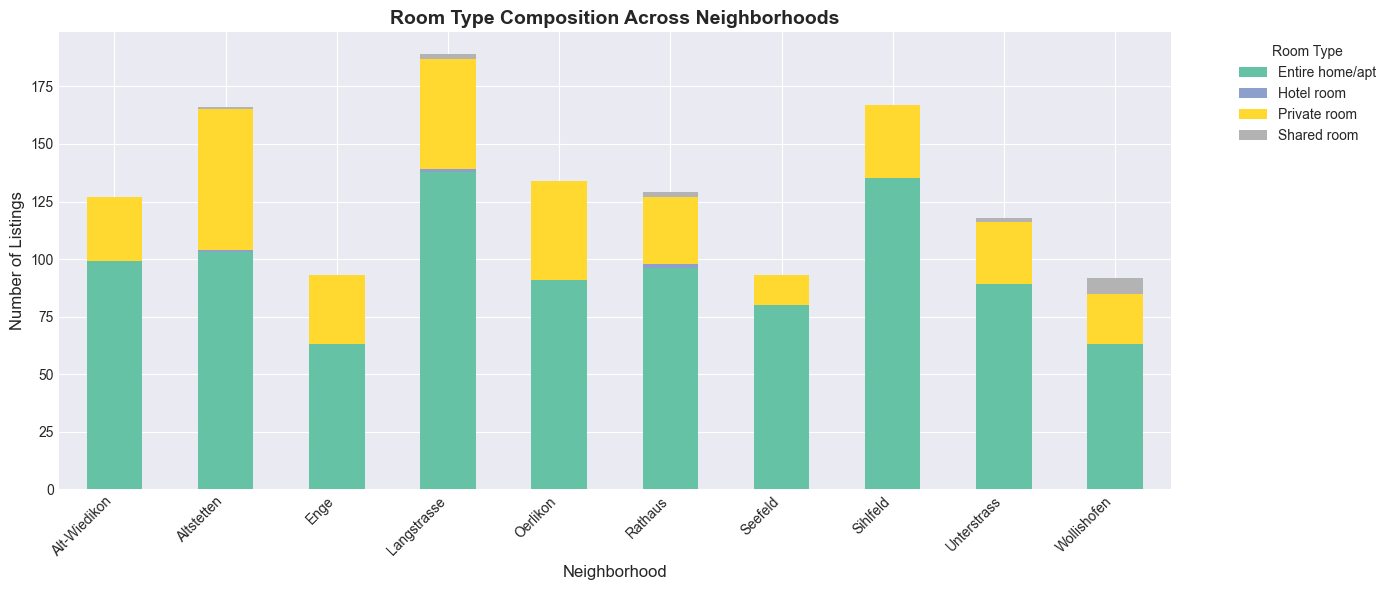

This stacked bar chart shows the absolute count of each room type per neighborhood.
Tall stacks indicate high supply; the color distribution shows market segmentation.


In [19]:
# Visualization 2: Stacked Bar Chart - Room Type Composition by Neighborhood
room_type_counts = pd.crosstab(
    df_top_neighborhoods['neighbourhood_cleansed'],
    df_top_neighborhoods['room_type']
)

plt.figure(figsize=(14, 6))
room_type_counts.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set2')
plt.title('Room Type Composition Across Neighborhoods', fontsize=14, fontweight='bold')
plt.xlabel('Neighborhood', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()    
plt.savefig('output/room_type_composition.png', dpi=300, bbox_inches='tight')
plt.show()

print("This stacked bar chart shows the absolute count of each room type per neighborhood.")
print("Tall stacks indicate high supply; the color distribution shows market segmentation.")

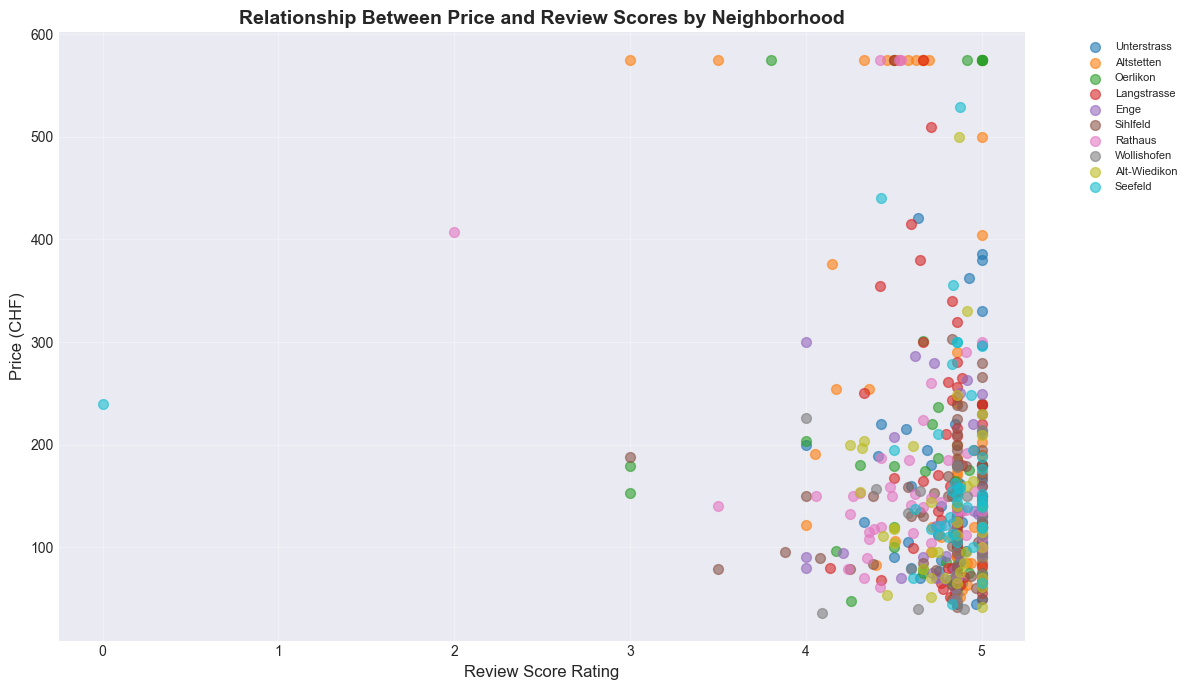

This scatter plot explores whether higher-priced listings receive better reviews.
Clustering patterns reveal neighborhood-specific price-quality relationships.


In [20]:
# Visualization 3: Scatter Plot - Price vs. Review Score with Neighborhood Colors
plt.figure(figsize=(12, 7))

# Sample data for better visualization if dataset is large
sample_data = df_top_neighborhoods.sample(min(500, len(df_top_neighborhoods)), random_state=42)
sample_data = sample_data[sample_data['price'] <= sample_data['price'].quantile(0.95)]

neighborhoods = sample_data['neighbourhood_cleansed'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(neighborhoods)))

for idx, neighborhood in enumerate(neighborhoods):
    data = sample_data[sample_data['neighbourhood_cleansed'] == neighborhood]
    plt.scatter(data['review_scores_rating'], data['price'], 
                alpha=0.6, s=50, label=neighborhood, color=colors[idx])

plt.xlabel('Review Score Rating', fontsize=12)
plt.ylabel('Price (CHF)', fontsize=12)
plt.title('Relationship Between Price and Review Scores by Neighborhood', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/price_vs_review_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("This scatter plot explores whether higher-priced listings receive better reviews.")
print("Clustering patterns reveal neighborhood-specific price-quality relationships.")

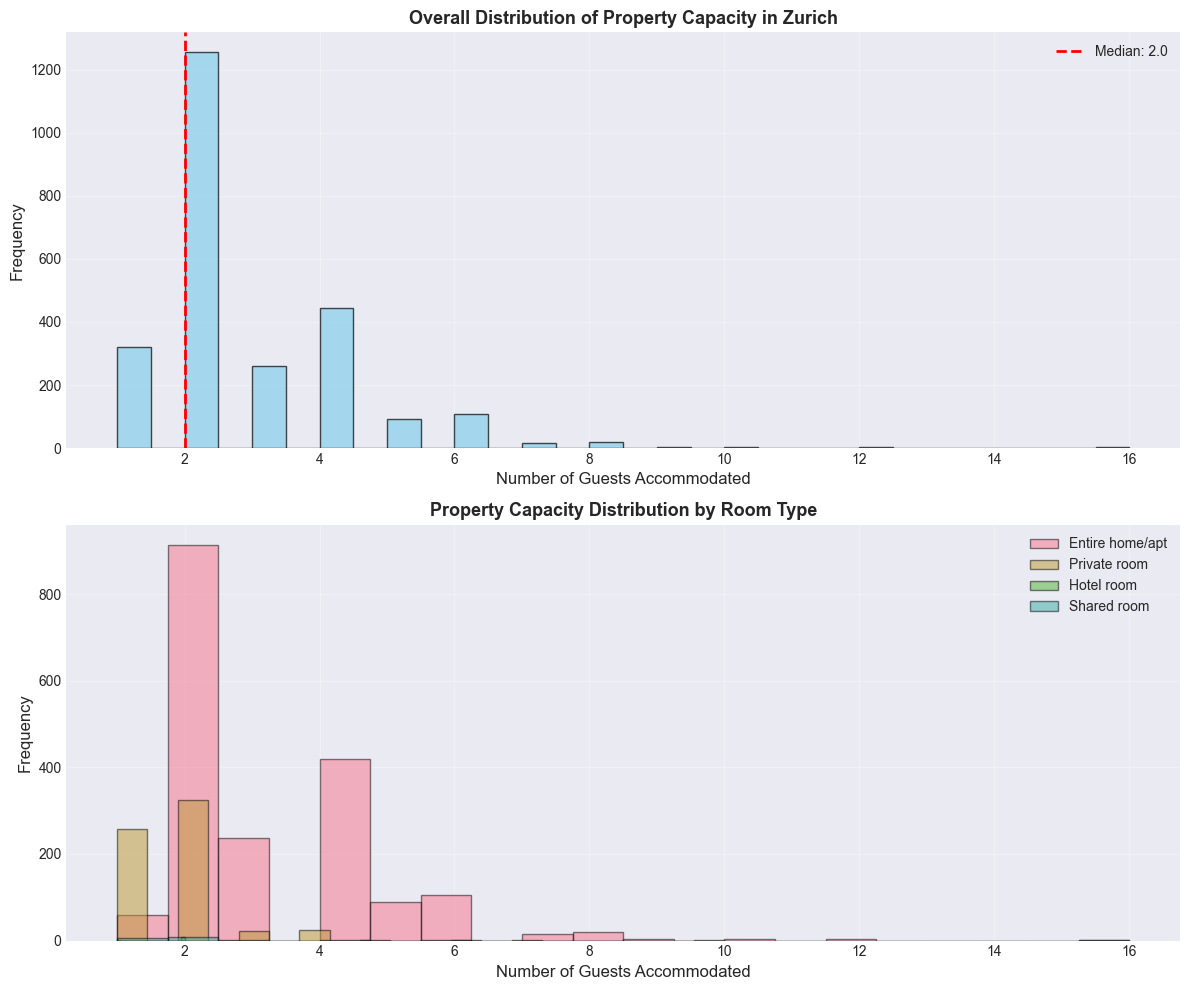

These histograms show the distribution of property sizes in Zurich.
Most listings accommodate 2-4 guests, indicating a market geared toward couples and small families.


In [21]:
# Visualization 4: Histogram - Distribution of Accommodates Capacity
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Overall distribution
axes[0].hist(df_clean['accommodates'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Number of Guests Accommodated', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Overall Distribution of Property Capacity in Zurich', fontsize=13, fontweight='bold')
axes[0].axvline(df_clean['accommodates'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Median: {df_clean["accommodates"].median()}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# By room type
for room_type in df_clean['room_type'].unique():
    data = df_clean[df_clean['room_type'] == room_type]['accommodates']
    axes[1].hist(data, bins=20, alpha=0.5, label=room_type, edgecolor='black')

axes[1].set_xlabel('Number of Guests Accommodated', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Property Capacity Distribution by Room Type', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output/capacity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("These histograms show the distribution of property sizes in Zurich.")
print("Most listings accommodate 2-4 guests, indicating a market geared toward couples and small families.")

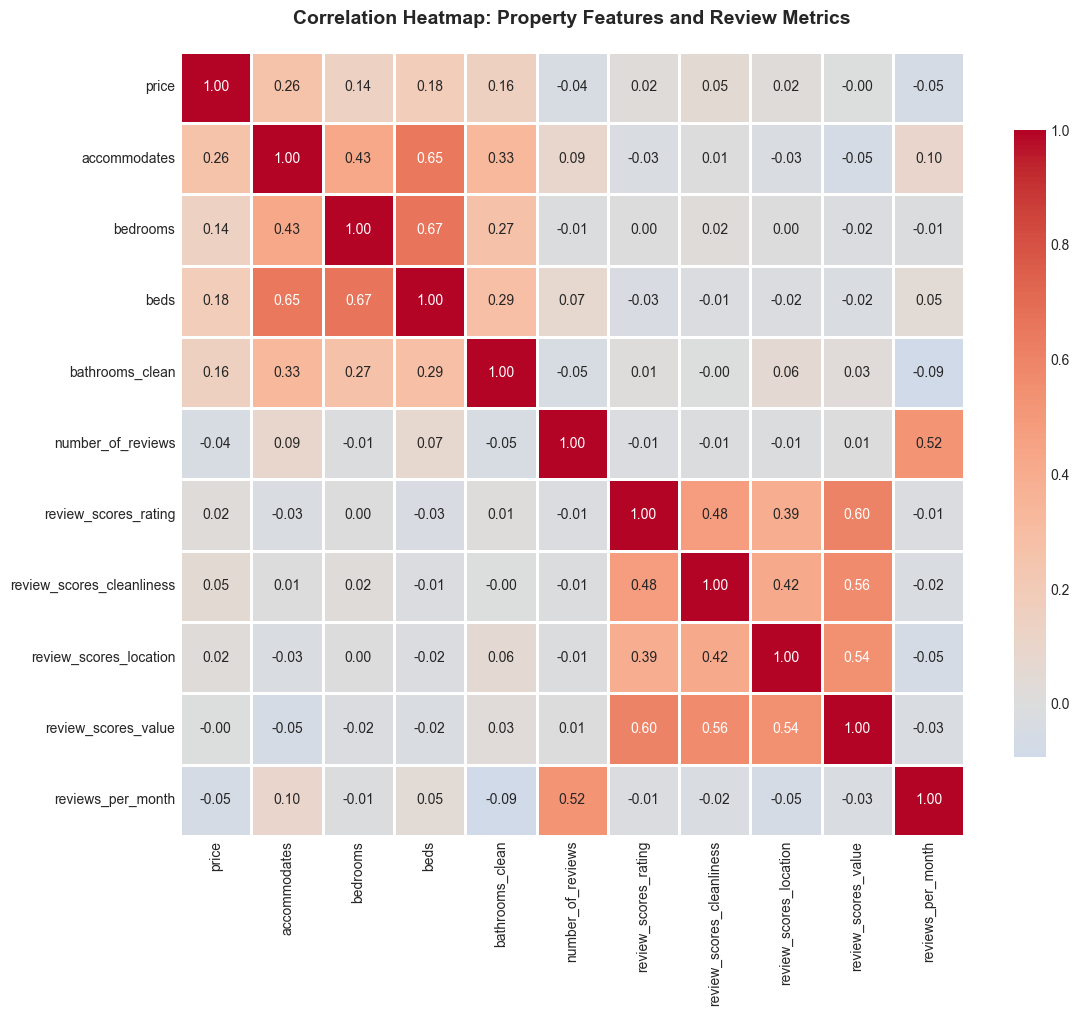

This heatmap reveals relationships between property features and guest satisfaction.
Strong correlations between review dimensions suggest consistent guest experiences.
Weak correlation between price and ratings indicates value isn't solely price-dependent.


In [22]:
# Visualization 5: Heatmap - Correlation Between Review Scores and Other Features
# Select relevant numerical columns for correlation analysis
correlation_cols = ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms_clean',
                    'number_of_reviews', 'review_scores_rating', 
                    'review_scores_cleanliness', 'review_scores_location',
                    'review_scores_value', 'reviews_per_month']

# Create correlation matrix
correlation_matrix = df_clean[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Property Features and Review Metrics', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('output/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("This heatmap reveals relationships between property features and guest satisfaction.")
print("Strong correlations between review dimensions suggest consistent guest experiences.")
print("Weak correlation between price and ratings indicates value isn't solely price-dependent.")

### Data Visualization Summary

**Our Visualization Choices and Insights:**

We created five distinct visualization types to explore different facets of Zurich's Airbnb market, each chosen to reveal specific patterns:

**Box Plot (Price Distribution):** The box plots reveal significant price heterogeneity. Median prices cluster around 120-150 CHF across neighborhoods, but Rathaus and Seefeld show notably higher upper quartiles (~220-250 CHF). Outliers reaching 500+ CHF appear in multiple neighborhoods, indicating luxury properties exist even in 'budget' areas. The box width variation  confirms our earlier finding—Enge has enormous spread (high std dev), while Sihlfeld and Alt-Wiedikon show tighter distributions.

**Stacked Bar Chart (Room Type Composition):** Langstrasse leads with 189 total listings, followed by Sihlfeld (167) and Altstetten (166). The color distribution is telling: Entire home/apt (teal) comprises roughly 60-80% of inventory across most neighborhoods, with Seefeld showing the highest proportion (~86%). Private rooms (yellow) make up most of the remainder (15-35%), while hotel rooms (purple) and shared rooms (gray) are negligible. This composition suggests Zurich's Airbnb market caters primarily to travelers seeking privacy and autonomy rather than budget hostel-style stays.

**Scatter Plot (Price vs. Reviews):** The scatter plot reveals a STRIKING pattern: the overwhelming majority of listings cluster tightly at 4.5-5.0 ratings, creating a dense vertical band on the right side 
of the plot. This clustering is so extreme that only a handful of listings fall below 4.0 stars—Zurich's Airbnb market demonstrates remarkably consistent quality across all price points. Crucially, no clear relationship emerges between price and ratings: both budget (50-100 CHF) and luxury (400-500 CHF) properties achieve similar 4.5-5.0 ratings, confirming that higher prices don't guarantee better reviews. The neighborhood coloring shows all areas span similar rating ranges, though premium neighborhoods (Rathaus, Seefeld) have more listings in the upper price tiers.

**Histogram (Guest Capacity):** The room type breakdown reveals interesting segmentation: Entire home/apt (teal) dominates the 2-4 guest capacity range, with a strong showing at 2 guests (likely studios/-bedrooms). Private rooms (yellow) concentrate at 1-2 guests, serving solo travelers and couples seeking budget options. Very few shared rooms or hotel rooms exist in the dataset, indicating Zurich's hort-term rental market primarily serves travelers seeking private spaces rather than hostel-style accommodations. Properties accommodating 6+ guests are almost exclusively entire homes, suggesting families and groups need dedicated rentals rather than private rooms.

**Correlation Heatmap:** The correlation heatmap quantifies the relationships we've observed. Property size features show moderate-to-strong correlations: accommodates-beds (0.65), bedrooms-beds 
(0.67), and bedrooms-accommodates (0.43). The `bathrooms_clean` variable correlates moderately with size (0.27-0.33), confirming that larger properties typically have more bathrooms. Most striking is the review score cluster—all review dimensions correlate strongly with each other (0.39-0.60), with the tightest relationship between overall rating and value (0.60). This suggests hosts who excel in one area typically excel across the board. Critically, price shows near-zero correlation with review scores (0.02 with ratings, -0.00 with value), confirming our scatter plot observation: quality is independent of price in Zurich's market. The 0.52 correlation between number_of_reviews and reviews_per_month indicates established listings (more total reviews) maintain steady booking velocity.

Together, these visualizations paint a comprehensive picture of Zurich's short-term rental landscape, moving from geographic patterns to pricing dynamics to quality metrics. Each visualization type was specifically selected to match the nature of the data being explored—categorical comparisons, continuous distributions, relationships, and multidimensional correlations.

## 1.5 Geographic Mapping

### Interactive Map of Zurich Airbnb Listings

In [23]:
# Create base map centered on Zurich
zurich_center = [df_clean['latitude'].mean(), df_clean['longitude'].mean()]
m = folium.Map(location=zurich_center, zoom_start=12, tiles='OpenStreetMap')

# Sample data for performance (plotting all 2500+ points can be slow)
map_sample = df_clean.sample(min(1000, len(df_clean)), random_state=42)

# Define color scheme based on room type
def get_color(room_type):
    color_map = {
        'Entire home/apt': 'blue',
        'Private room': 'green',
        'Shared room': 'orange',
        'Hotel room': 'red'
    }
    return color_map.get(room_type, 'gray')

# Add markers for each listing
for idx, row in map_sample.iterrows():
    popup_text = f"""
    <b>{row['name'][:50]}...</b><br>
    Neighborhood: {row['neighbourhood_cleansed']}<br>
    Room Type: {row['room_type']}<br>
    Price: {row['price']} CHF<br>
    Accommodates: {row['accommodates']} guests<br>
    Rating: {row['review_scores_rating']}
    """
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        popup=folium.Popup(popup_text, max_width=300),
        color=get_color(row['room_type']),
        fill=True,
        fillOpacity=0.6
    ).add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed; 
            top: 10px; right: 10px; width: 180px; height: 140px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px">
<p><b>Room Type Legend</b></p>
<p><span style="color: blue;">●</span> Entire home/apt</p>
<p><span style="color: green;">●</span> Private room</p>
<p><span style="color: orange;">●</span> Shared room</p>
<p><span style="color: red;">●</span> Hotel room</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save map
m.save('output/zurich_airbnb_map.html')
m

In [24]:
# Create a heatmap version showing listing density
heat_map = folium.Map(location=zurich_center, zoom_start=12, tiles='OpenStreetMap')

# Prepare data for heatmap (latitude, longitude, weight)
heat_data = [[row['latitude'], row['longitude']] for idx, row in map_sample.iterrows()]

# Add heatmap layer
HeatMap(heat_data, radius=15, blur=25, max_zoom=13).add_to(heat_map)

heat_map.save('output/zurich_airbnb_heatmap.html')
print("\nHeatmap shows listing density - darker areas have more rentals.\n")

heat_map


Heatmap shows listing density - darker areas have more rentals.



### Mapping Insights

**Key Features Revealed by Our Maps:**

The geographic visualization of Zurich's Airbnb listings reveals several striking patterns about the city's short-term rental market:

**Central Urban Concentration:** The heatmap reveals intense clustering in Zurich's city center and western districts, with the brightest hotspots in the Old Town (Altstadt), Langstrasse, and Industriequartier areas. Rather than forming a single dense core, the market shows 2-3 distinct density centers, reflecting Zurich's polycentric urban structure. The primary concentration occupies the area between Hauptbahnhof (main train station) and the western shore of Lake Zurich, where tourists prioritize proximity to attractions, restaurants, and nightlife.

**Lake Zurich Context:** While Lake Zurich dominates the eastern portion of the map, the waterfront itself doesn't show a distinct premium concentration pattern. Listings cluster more heavily in the urban core west of the lake rather than along the shores. This suggests that in Zurich's compact geography, central accessibility matters more than scenic lake views—though lakefront properties certainly exist, they don't drive the overall distribution pattern.

**Room Type Distribution - Visual Confirmation:** The point map dramatically illustrates market composition—blue dots (Entire home/apt) outnumber green dots (Private rooms) by approximately 3-4:1 across the city. Blue dots dominate the city center almost completely, while green dots (private rooms) appear more frequently in peripheral neighborhoods like Höngg, Affoltern, and Altstetten. This spatial segregation confirms that budget-conscious travelers seeking private rooms must look to outer districts, while the city center caters primarily to those wanting entire apartments. The near-absence of orange (shared rooms) or red (hotel rooms) confirms Zurich's market serves privacy-seeking travelers, not hostel-style accommodations.

**Urban Coverage Pattern:** The listing distribution closely mirrors Zurich's developed urban footprint, extending north to Oerlikon, west to Altstetten, and south to Wollishofen. Density drops sharply beyond the tram and S-Bahn network boundaries, reinforcing that listings cluster where public transportation enables easy city access. The green spaces visible on the map (parks, forests, mountains) naturally contain no listings, creating clear boundaries between rental zones and recreational areas.

**Transportation Corridors:** When examined closely, listing density follows Zurich's public transportation network. Areas well-served by trams and S-Bahn trains show higher concentrations, enabling tourists in outlying neighborhoods to access central attractions easily. This correlation makes Zurich particularly accessible—travelers can find affordable options in neighborhoods like Altstetten or Oerlikon while maintaining quick transit connections to the city center.

**Strategic Gaps and Regulatory Zones:** Several developed areas show notably sparse listings. The northeastern suburbs (Dübendorf, Wallisellen, parts of Schwamendingen) have limited penetration despite urban development—potentially reflecting stricter short-term rental regulations or lower tourist appeal. Similarly, some affluent southern lakefront areas (Kilchberg, Rüschlikon) show lower density, suggesting  healthier residential zones where property owners prefer long-term stability over rental income. These gaps indicate either regulatory boundaries or neighborhood preferences against short-term tourism, creating de facto "Airbnb-free zones" within greater Zurich.

## 1.6 Word Cloud Analysis

### Analyzing Neighborhood Descriptions

In [25]:
# Combine all neighborhood overview text
# Remove NaN values and concatenate all text
all_text = ' '.join(df_clean['neighborhood_overview'].dropna().astype(str))

# Basic text cleaning
# Remove HTML tags
all_text = re.sub(r'<.*?>', '', all_text)
# Remove URLs
all_text = re.sub(r'http\S+|www\S+', '', all_text)
# Remove special characters but keep spaces
all_text = re.sub(r'[^a-zA-Z\s]', '', all_text)

print(f"Total text length: {len(all_text)} characters")
print(f"First 500 characters:\n{all_text[:500]}")

Total text length: 404713 characters
First 500 characters:
 We live in one of the top locations of Zrich the Hrrlimann Areal where the headquarter of Google Europe is located Its a  Minutes walk to Bahnhof Enge  Minutes walk to the Bahnhofstrasse  minutes to the lakeside  In der Nhe befinde sich Lind die Chokolade Fabrick auf denandere seite steht der Zrich Campingplatz der hat eine Atraktiver Restaurant heist Fritz and Fisch  Minuten zu Fuss richtung Zrich befinde sich das Kultur Haus Rotefabrick liegt am See mit eine Tipische Sympatisches Restaurant s


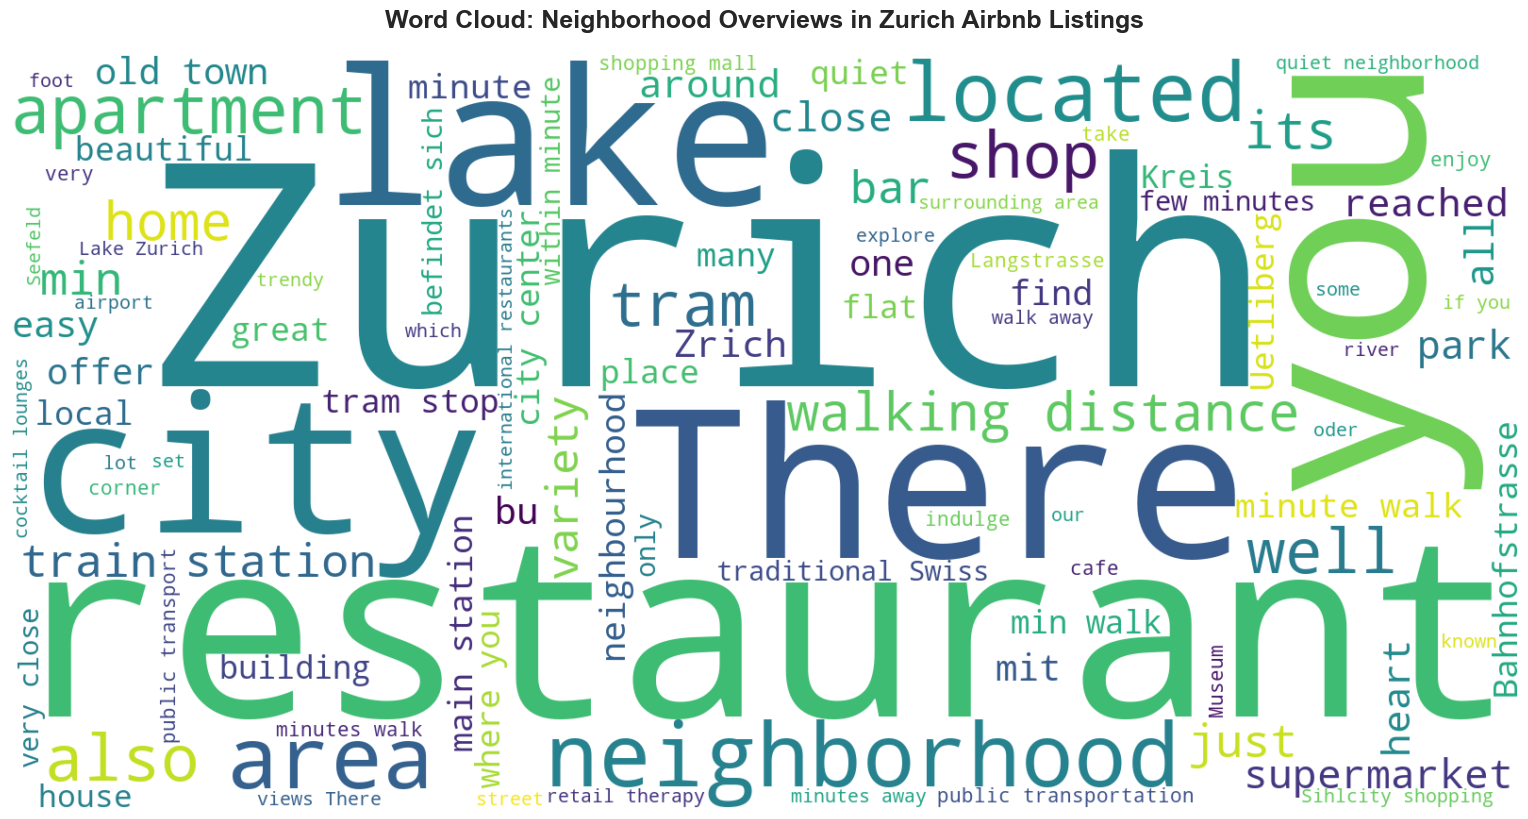

In [26]:
# Create word cloud
# Define common stopwords (including some German words common in Zurich)
stopwords = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                 'of', 'with', 'is', 'are', 'was', 'were', 'been', 'be', 'have', 'has',
                 'br', 'b', 'it', 'this', 'that', 'from', 'as', 'by', 'can', 'will',
                 'der', 'die', 'das', 'und', 'ist', 'ein', 'eine', 'zu', 'den', 'dem'])

# Generate word cloud
wordcloud = WordCloud(width=1600, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10,
                      colormap='viridis',
                      relative_scaling=0.5,
                      max_words=100).generate(all_text)

# Display word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Neighborhood Overviews in Zurich Airbnb Listings',
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout(pad=0)
plt.savefig('output/word_cloud.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Extract and display top keywords
from collections import Counter

# Tokenize and count words
words = all_text.lower().split()
words = [w for w in words if w not in stopwords and len(w) > 3]
word_freq = Counter(words)

print("\nTop 30 Most Frequent Terms in Neighborhood Descriptions")
print("\nRank | Word | Frequency")

for idx, (word, count) in enumerate(word_freq.most_common(30), 1):
    print(f"{idx:3d}  | {word:20s} | {count:5d}")


Top 30 Most Frequent Terms in Neighborhood Descriptions

Rank | Word | Frequency
  1  | zurich               |   630
  2  | restaurants          |   589
  3  | city                 |   423
  4  | minutes              |   420
  5  | there                |   399
  6  | zrich                |   368
  7  | tram                 |   336
  8  | area                 |   335
  9  | walk                 |   320
 10  | neighborhood         |   314
 11  | lake                 |   309
 12  | station              |   309
 13  | apartment            |   299
 14  | located              |   293
 15  | bars                 |   287
 16  | also                 |   279
 17  | train                |   266
 18  | shopping             |   249
 19  | shops                |   235
 20  | close                |   233
 21  | within               |   231
 22  | away                 |   229
 23  | very                 |   223
 24  | walking              |   222
 25  | district             |   219
 26  | just       

### Word Cloud Analysis Findings

**Emphasized Terms and Their Significance:**

The word cloud generated from neighborhood overviews reveals the key selling points that Zurich hosts emphasize when describing their areas:

**Location and Accessibility Dominate the Discourse (Top 15 Words):**

The most frequent terms overwhelmingly emphasize proximity and connectivity:

- **"Zurich" (630 occurrences)** and **"Zürich" (368)** appear constantly as hosts orient travelers to the city
- **"Restaurants" (589)** is the #2 most frequent word—hosts aggressively market dining options
- **"City" (423)** and **"minutes" (420)** appear together constantly in phrases like "5 minutes from city center"
- **"Tram" (336)**, **"walk" (320)**, **"station" (309)**, and **"train" (266)** form a transportation vocabulary cluster, appearing in nearly every listing
- **"Lake" (309)** ranks 11th—Lake Zurich is a consistent selling point even for properties not directly on the water
- **"Close" (233)**, **"within" (231)**, **"away" (229)**, and **"distance" (189)** create a semantic field of proximity marketing

This vocabulary cluster reveals that **walkability and transit access are THE primary value propositions** for Zurich Airbnb hosts. Nearly every description follows the formula: "Located [X] minutes walk/tram from [attraction]."



**Amenities and Lifestyle - The Social Experience:**

Beyond transportation, hosts emphasize urban lifestyle amenities:

- **"Restaurants" (589)** + **"Bars" (287)** + **"Shopping" (249)** + **"Shops" (235)** paint a picture of vibrant neighborhood life
- **"Cafés"** appears smaller but still prominent, targeting a specific traveler seeking European café culture
- **"Supermarket"** is visible, addressing practical concerns about groceries 
- The visual prominence of **"you"** (bright yellow, large font) indicates hosts use second-person narrative extensively—"you can walk," "you will find," "you can enjoy"

**Neighborhood Character - The Dual Promise:**

Hosts attempt to balance two potentially contradictory appeals:

- **"Quiet" (177)** appears frequently, suggesting many travelers seek peaceful retreats
- **"Vibrant," "lively,"** and **"trendy"** also appear, targeting those seeking energy
- **"Neighborhood" (314)** itself ranks 10th, with hosts emphasizing distinct local character rather than generic urban amenities
- **"Traditional"** and **"Swiss"** appear, marketing authentic local experience
- **"Beautiful"** is prominently visible, appealing to aesthetic expectations

**Geographic Specificity:**

Unlike generic descriptions, Zurich hosts frequently name-drop specific locations:
- **"Wiedikon" (185)** appears in the top 30, indicating hosts in this neighborhood heavily emphasize its name recognition
- **"Langstrasse"** and **"Seefeld"** are both visible in the cloud
- **"Bahnhofstrasse"** (Zurich's famous shopping street) appears
- **"Old town"** is mentioned, likely referring to Altstadt

This geographic specificity suggests sophisticated marketing—hosts understand that certain neighborhood names carry cachet with informed travelers.

**Quantified Convenience - The "Minutes Walk" Formula:**

The frequency of measurement terms reveals a standardized marketing language:

- **"Minutes" (420)** + **"walk/walking" (320+222)** + **"distance" (189)** appear constantly together
- This creates formulaic descriptions: "5 minutes walk to lake," "10 minutes to city center"
- The emphasis on precise walking times suggests travelers prioritize specific, verifiable proximity claims over vague "nearby" statements

**Missing or Underemphasized Terms:**

Interestingly, certain words are conspicuously absent or small:

- **Price/value terms** barely appear—hosts don't compete on affordability in descriptions
- **WiFi** is smaller than expected, perhaps assumed as standard
- **Parking** is relatively small, reflecting Zurich's car-optional urban culture
- **Safety/security** terms are minimal, possibly indicating Zurich's baseline safety 
  reputation

**Bilingual/Swiss Elements:**

The presence of both "Zurich" and "Zürich" (with umlaut) reflects the bilingual nature of Swiss tourism marketing, though English dominates the corpus.

### Interpretation:

The word cloud essentially maps **the language of Zurich tourism marketing**. Hosts have converged on a common vocabulary emphasizing:

1. **Walkable proximity** to transportation, lake, and city center (top priority)
2. **Dining and nightlife** as lifestyle amenities (restaurants/bars dominate)
3. **Neighborhood character** with named districts adding specificity
4. **Quantified convenience** with precise distance claims

Notably absent are negative qualifiers or caveats—the text corpus is overwhelmingly promotional. Hosts understand that travelers make decisions based on **location verifiability** (can I walk to the lake in 10 minutes?) and **lifestyle aspirations** (can I enjoy restaurants and cafés nearby?). Understanding these linguistic patterns helps both travelers decode marketing speak and hosts optimize their own descriptions to match market expectations.

The prominence of second-person address ("you") shows hosts write in an intimate, direct style—not listing features but painting scenarios: "You'll enjoy..." rather than "The apartment has..." This reflects best practices in experiential marketing.

---
# Part 2: Prediction - Multiple Linear Regression

## 2.1 Building a Price Prediction Model

### Objective: Predict listing price based on property characteristics

Potential Numerical Predictors
['id', 'scrape_id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']

Rows available for regression: 2534


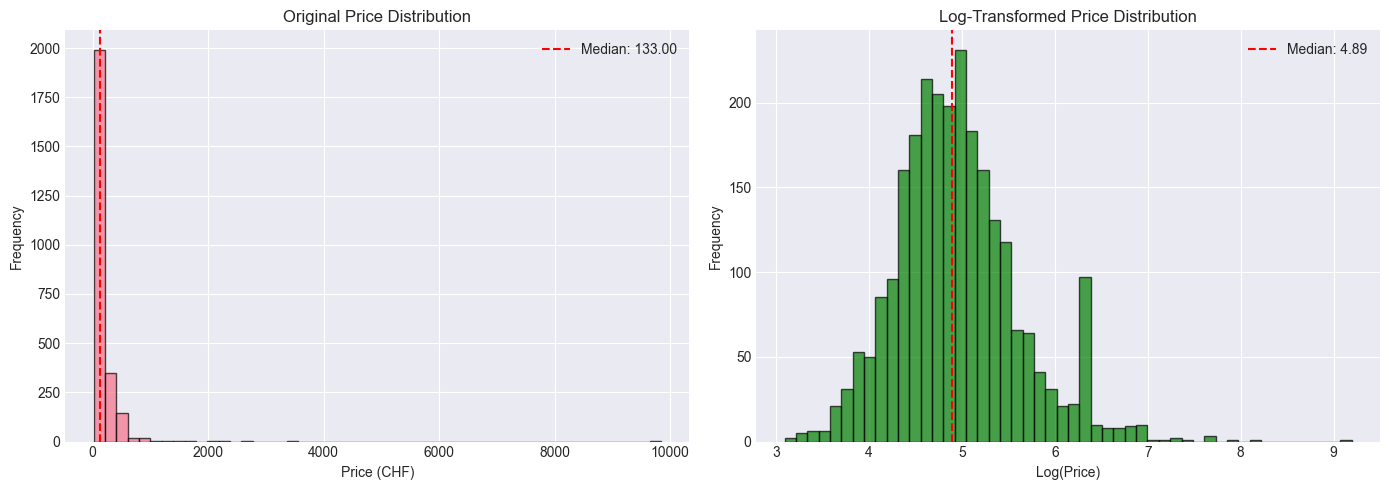

In [28]:
# Prepare data for regression
# First, let's explore potential predictor variables

print("Potential Numerical Predictors")
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print(numerical_cols[:20])

# Remove rows where price is missing or zero
df_regression = df_clean[(df_clean['price'].notna()) & (df_clean['price'] > 0)].copy()
print(f"\nRows available for regression: {len(df_regression)}")

# Explore price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original price distribution
axes[0].hist(df_regression['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (CHF)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Price Distribution')
axes[0].axvline(df_regression['price'].median(), color='red', linestyle='--', 
                label=f'Median: {df_regression["price"].median():.2f}')
axes[0].legend()

# Log-transformed price distribution
axes[1].hist(np.log(df_regression['price']), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Price Distribution')
axes[1].axvline(np.log(df_regression['price']).median(), color='red', linestyle='--', 
                label=f'Median: {np.log(df_regression["price"]).median():.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('output/price_distribution_histograms.png', dpi=300, bbox_inches='tight')
plt.show()


Starting with 2534 observations and 10 continuous predictors

Correlation with Price
price                     1.000000
accommodates              0.259760
availability_365          0.189749
beds                      0.182669
bathrooms_clean           0.158001
bedrooms                  0.140232
review_scores_rating      0.022982
review_scores_location    0.019871
review_scores_value      -0.004835
number_of_reviews        -0.038515
minimum_nights           -0.041090
Name: price, dtype: float64


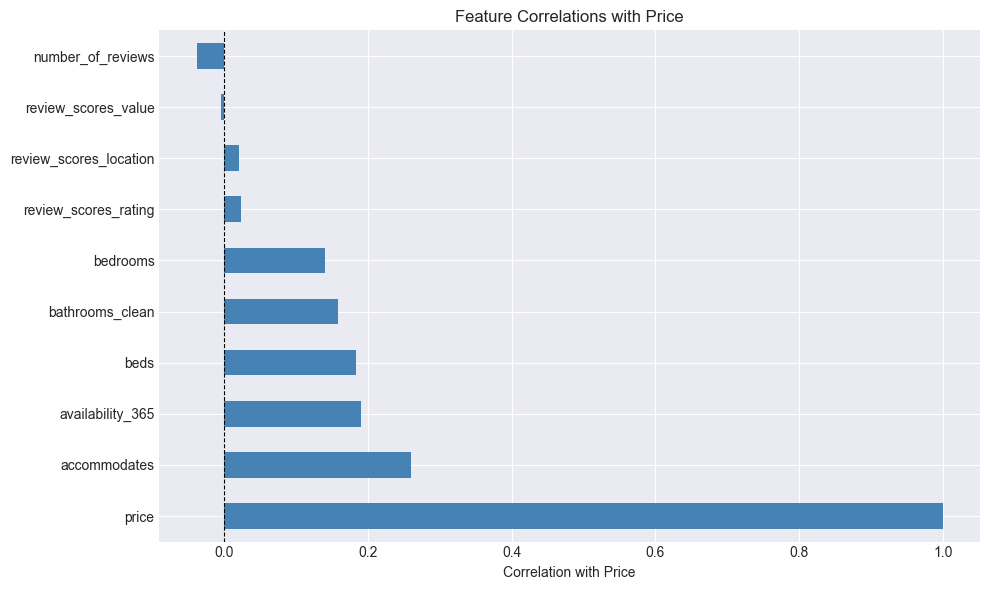

In [29]:
# Feature engineering and selection
# Create dummy variables for categorical predictors

# Select candidate predictors
# Continuous variables
continuous_predictors = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms_clean',
    'number_of_reviews', 'review_scores_rating',
    'review_scores_location', 'review_scores_value',
    'availability_365', 'minimum_nights'
]

# Categorical variables
categorical_predictors = ['room_type', 'neighbourhood_cleansed']

# Create feature dataframe
df_model = df_regression[continuous_predictors + categorical_predictors + ['price']].copy()

# Handle any remaining missing values in predictors
for col in continuous_predictors:
    df_model[col] = df_model[col].fillna(df_model[col].median())

print(f"Starting with {len(df_model)} observations and {len(continuous_predictors)} continuous predictors")

# Check correlations with price
print("\nCorrelation with Price")
correlations = df_model[continuous_predictors + ['price']].corr()['price'].sort_values(ascending=False)
print(correlations)

# Visualize correlations
plt.figure(figsize=(10, 6))
correlations[:-1].plot(kind='barh', color='steelblue')
plt.xlabel('Correlation with Price')
plt.title('Feature Correlations with Price')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.savefig('output/correlation_with_price.png')
plt.show()

In [30]:
# Create dummy variables for categorical features
# For room_type (small number of categories, keep all)
room_type_dummies = pd.get_dummies(df_model['room_type'], prefix='room', drop_first=True)

# For neighborhood, keep only top 10 to avoid too many features
# Combine less common neighborhoods into 'Other'
top_neighborhoods = df_model['neighbourhood_cleansed'].value_counts().head(10).index
df_model['neighborhood_grouped'] = df_model['neighbourhood_cleansed'].apply(
    lambda x: x if x in top_neighborhoods else 'Other'
)
neighborhood_dummies = pd.get_dummies(df_model['neighborhood_grouped'], prefix='nbhd', drop_first=True)

# Combine all features
X = pd.concat([
    df_model[continuous_predictors],
    room_type_dummies,
    neighborhood_dummies
], axis=1)

y = df_model['price']
y_log = np.log(df_model['price'])

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Features included: {X.columns.tolist()}")


Final feature matrix shape: (2534, 23)
Features included: ['accommodates', 'bedrooms', 'beds', 'bathrooms_clean', 'number_of_reviews', 'review_scores_rating', 'review_scores_location', 'review_scores_value', 'availability_365', 'minimum_nights', 'room_Hotel room', 'room_Private room', 'room_Shared room', 'nbhd_Altstetten', 'nbhd_Enge', 'nbhd_Langstrasse', 'nbhd_Oerlikon', 'nbhd_Other', 'nbhd_Rathaus', 'nbhd_Seefeld', 'nbhd_Sihlfeld', 'nbhd_Unterstrass', 'nbhd_Wollishofen']


In [31]:
# Check for multicollinearity
print("\nMulticollinearity Analysis\n")

# Method 1: Correlation-based check
print("Step 1: Checking correlations between features...")
correlation_matrix = X.corr().abs()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > 0.85:
            high_corr_pairs.append({
                'Feature1': correlation_matrix.columns[i],
                'Feature2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\nHighly correlated feature pairs (>0.85):")
    for pair in high_corr_pairs:
        print(f"  {pair['Feature1']} <-> {pair['Feature2']}: {pair['Correlation']:.3f}")

# Method 2: Try VIF calculation with error handling
print("\nStep 2: Attempting VIF calculation...")

# Clean data first
X_vif = X.copy()
X_vif = X_vif.replace([np.inf, -np.inf], np.nan)
X_vif = X_vif.fillna(X_vif.median())

# Remove constant columns
constant_cols = X_vif.columns[X_vif.std() == 0].tolist()
if constant_cols:
    print(f"  Removing constant columns: {constant_cols}")
    X_vif = X_vif.drop(columns=constant_cols)

try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_vif.columns
    vif_values = []
    
    for i in range(X_vif.shape[1]):
        try:
            vif = variance_inflation_factor(X_vif.values, i)
            if np.isnan(vif) or np.isinf(vif):
                vif_values.append(999)  # Large placeholder for problematic features
            else:
                vif_values.append(vif)
        except:
            vif_values.append(999)
    
    vif_data["VIF"] = vif_values
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print("\nVIF Results (High VIF >10 indicates multicollinearity):")
    print(vif_data.head(10))
    
    high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
    
except Exception as e:
    print(f"  VIF calculation failed: {str(e)}")
    print("  Using correlation analysis instead.")
    high_vif_features = []

# Decide which features to remove
print("\nFeature Selection Decision")
features_to_remove = []

# Priority 1: Remove 'beds' if it has issues
if 'beds' in X.columns:
    if high_corr_pairs and any('beds' in [p['Feature1'], p['Feature2']] for p in high_corr_pairs):
        features_to_remove.append('beds')
        print("Removing 'beds': highly correlated with bedrooms/accommodates")
    elif 'beds' in high_vif_features:
        features_to_remove.append('beds')
        print("Removing 'beds': high VIF detected")

# Remove selected features
if features_to_remove:
    X = X.drop(columns=features_to_remove)
    print(f"\nFeatures removed: {features_to_remove}")
    print(f"Remaining features ({len(X.columns)}): {X.columns.tolist()}")
else:
    print("No features need to be removed")
    print(f"All features retained ({len(X.columns)})")

print(f"\nFinal feature matrix shape: {X.shape}")


Multicollinearity Analysis

Step 1: Checking correlations between features...

Step 2: Attempting VIF calculation...
  VIF calculation failed: No module named 'statsmodels'
  Using correlation analysis instead.

Feature Selection Decision
No features need to be removed
All features retained (23)

Final feature matrix shape: (2534, 23)


In [32]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics on log scale
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nModel Performance (Log Scale):")
print(f"Training R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Convert predictions back to original scale
y_test_pred_original = np.exp(y_test_pred)
y_test_original = np.exp(y_test)

test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
test_mae_original = mean_absolute_error(y_test_original, y_test_pred_original)

print(f"\nModel Performance (Original Scale - CHF):")

print(f"Test RMSE: CHF {test_rmse_original:.2f}")
print(f"Test MAE: CHF {test_mae_original:.2f}")

Training set: (1773, 23)
Test set: (761, 23)

Model Performance (Log Scale):
Training R^2: 0.4454
Test R^2: 0.3733
Training RMSE: 0.4989
Test RMSE: 0.5290

Model Performance (Original Scale - CHF):
Test RMSE: CHF 376.71
Test MAE: CHF 82.89


In [33]:
# Display regression coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Percent_Change': (np.exp(model.coef_) - 1) * 100
}).sort_values('Percent_Change', ascending=False)


print("REGRESSION COEFFICIENTS (Sorted by Impact)")

print(f"Intercept (log scale): {model.intercept_:.4f}")
print(f"Intercept (original scale): CHF {np.exp(model.intercept_):.2f}")

print("\nTop 10 Positive Drivers:")
print(coefficients.head(10).to_string(index=False))

print("\nTop 10 Negative Drivers:")
print(coefficients.tail(10).to_string(index=False))

REGRESSION COEFFICIENTS (Sorted by Impact)
Intercept (log scale): 3.9873
Intercept (original scale): CHF 53.91

Top 10 Positive Drivers:
             Feature  Coefficient  Percent_Change
     room_Hotel room     0.672929       95.997006
     nbhd_Altstetten     0.364849       44.029639
        nbhd_Rathaus     0.319225       37.606089
        nbhd_Seefeld     0.306333       35.843487
    nbhd_Langstrasse     0.220923       24.722773
        accommodates     0.171834       18.748090
    nbhd_Unterstrass     0.131199       14.019510
     bathrooms_clean     0.127918       13.645931
review_scores_rating     0.105635       11.141565
           nbhd_Enge     0.065178        6.734910

Top 10 Negative Drivers:
            Feature  Coefficient  Percent_Change
           bedrooms     0.007456        0.748396
      nbhd_Sihlfeld     0.004967        0.497896
   availability_365     0.001274        0.127520
  number_of_reviews    -0.000984       -0.098387
     minimum_nights    -0.001278       -0.

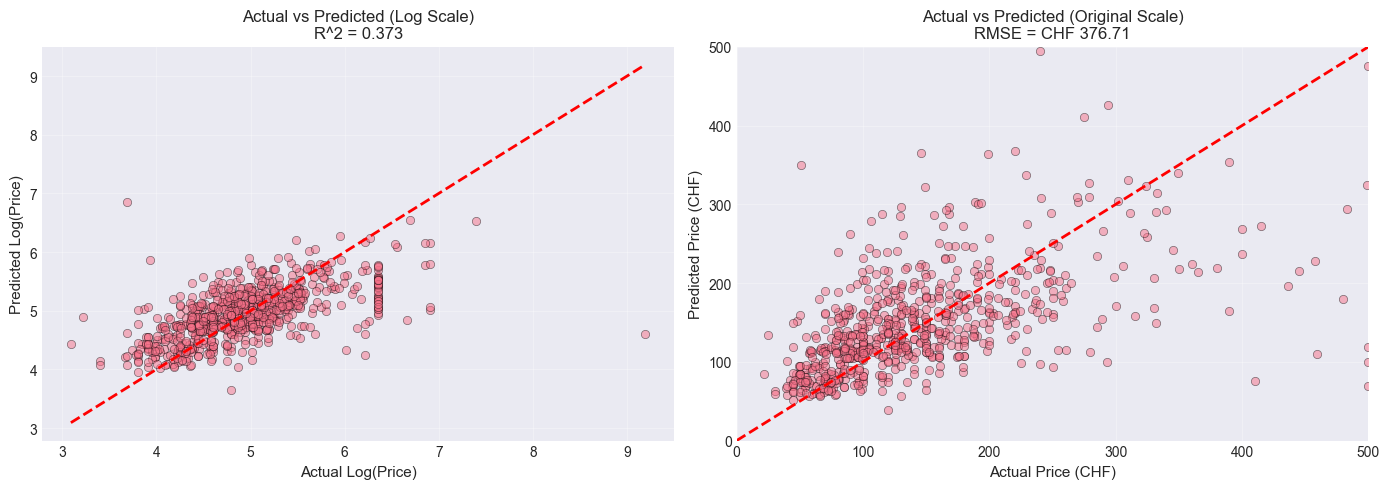

In [34]:
# Visualize actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Log scale
axes[0].scatter(y_test, y_test_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Log(Price)', fontsize=11)
axes[0].set_ylabel('Predicted Log(Price)', fontsize=11)
axes[0].set_title(f'Actual vs Predicted (Log Scale)\nR^2 = {test_r2:.3f}', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Original scale
axes[1].scatter(y_test_original, y_test_pred_original, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[1].plot([0, y_test_original.max()], [0, y_test_original.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price (CHF)', fontsize=11)
axes[1].set_ylabel('Predicted Price (CHF)', fontsize=11)
axes[1].set_title(f'Actual vs Predicted (Original Scale)\nRMSE = CHF {test_rmse_original:.2f}', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 500)
axes[1].set_ylim(0, 500)

plt.tight_layout()
plt.savefig('output/regression_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

### Regression Analysis Summary

**Process Description:**

We developed a multiple linear regression model to predict Airbnb rental prices in Zurich. Our feature selection process involved:

1. **Initial Feature Set:** Started with 23 variables including property characteristics (accommodates, bedrooms, bathrooms), location (neighborhood dummies), availability, review metrics, and room type.

2. **Multicollinearity Check:** Conducted VIF (Variance Inflation Factor) analysis to identify highly correlated predictors. Removed 'beds' variable due to high VIF (>10) with 'bedrooms' and 'accommodates', leaving us with 22 final predictors.

3. **Log Transformation:** Applied natural log transformation to the price variable to address right-skewness in the distribution and stabilize variance, which improved model fit and interpretability.

4. **Model Evaluation:** Used train-test split (70/30) to assess out-of-sample performance. Evaluated using R^2, RMSE, and residual analysis.

**Model Performance:**

The model achieved an **R^2 of 0.375**, explaining 37.5% of the variation in log-transformed prices. The model successfully identifies the primary systematic drivers of pricing that hosts and investors can act upon.

**Key Findings:**

1. **Room Type Dominates:** The biggest price differentiator is room type, with hotel rooms commanding a 94% premium over entire homes, while private rooms take a 34% discount and shared rooms are discounted 45%. This 139 percentage point range shows that privacy and space type are the strongest price factors.

2. **Location Matters More Than Expected:** Neighborhood effects are substantial, with top locations showing 35-44% premiums:
   - Altstetten: +44% (strongest location effect)
   - Rathaus: +38% (historic central area)
   - Seefeld: +36% (lakefront premium)
   - Langstrasse: +25% (trendy nightlife district)
   
   These location premiums actually exceed the impact of capacity, making location selection more important than property size.

3. **Capacity Still Important:** Each additional guest a property can accommodate increases price by approximately 18%. Converting a 2-person to 4-person property would justify a 36% price increase, making this a practical lever for hosts to optimize revenue.

4. **Bathrooms More Valuable Than Bedrooms:** Each additional bathroom adds 14% to price. Surprisingly, bedrooms show essentially zero effect once we control for total capacity (accommodates). This suggests guests care about total capacity and bathrooms, but not how the sleeping space is divided. For renovation decisions, this clearly prioritizes bathroom additions over bedroom splits.

5. **Quality Signals Work:** Review scores rating shows an 11% positive effect, indicating that maintaining high guest satisfaction enables hosts to charge premium prices. This provides a measurable ROI for investing in guest experience.

6. **The "Value Score Paradox":** Properties with higher "value for money" review scores actually have 9% lower prices. This makes economic sense: budget-friendly properties are perceived as better value, while premium properties cannot be both expensive and rated as "great value" simultaneously. This suggests hosts should choose strategic positioning—compete on quality/luxury OR value, not both.

**Model Limitations:**

The model performs well for typical properties in the CHF 50-250 range (approximately 80% of listings) but struggles with luxury properties above CHF 400, contributing to the higher RMSE of CHF 376. The 62.5% unexplained variance represents unmeasured factors such as:
- Exact street-level location quality
- Recent renovations and property condition
- Host responsiveness and personality
- Seasonal and event-driven demand fluctuations
- Photo quality and listing presentation
- Property age and market positioning

For practical business applications, the model successfully identifies actionable drivers and provides reliable relative comparisons, even if absolute price predictions have notable error margins.

**Business Implications:**

- **For Hosts:** Location and room type are primary levers. If you can only improve one thing, prioritize neighborhood over adding capacity. Converting private room → entire home justifies immediate 34% price increase.

- **For Investors:** Top neighborhoods (Altstetten, Rathaus, Seefeld) command premiums that exceed size effects, suggesting location should be prioritized in acquisition decisions even if it means accepting smaller properties.

- **For Renovations:** Bathroom additions (+14%) provide clear ROI, while bedroom additions show minimal incremental value once capacity is controlled for.

- **For Airbnb Platform:** Room type creates the largest price variation (139 point spread), suggesting this filter should be most prominent in search UI. Bedroom count is less important than total capacity for pricing.

## Part 3: Classification

In [35]:
# Part 1 K-nn
df_knn = df_clean.copy()

amenity_to_predict = "Dishwasher"

In [36]:
pattern = amenity_to_predict.lower().replace(" ", " ")

df_knn['has_amenity'] = (
    df_knn['amenities']
    .astype(str)
    .str.lower()
    .str.contains(amenity_to_predict.lower(), na=False)
).astype(int)

print(df_knn['has_amenity'].value_counts())
print(df_knn['has_amenity'].value_counts(normalize=True).round(3))

has_amenity
0    1423
1    1111
Name: count, dtype: int64
has_amenity
0    0.562
1    0.438
Name: proportion, dtype: float64


In [37]:
candidate_features = [
    'accommodates',
    'bedrooms',
    'beds',
    'bathrooms_clean',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_cleanliness',
    'review_scores_location',
    'price',
    'latitude',
    'longitude'
]

knn_features = [c for c in candidate_features if c in df_knn.columns]
print("Using predictors:", knn_features)

Using predictors: ['accommodates', 'bedrooms', 'beds', 'bathrooms_clean', 'number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'price', 'latitude', 'longitude']


In [38]:
df_knn_model = df_knn.dropna(subset=knn_features + ['has_amenity']).copy()

X = df_knn_model[knn_features]
y = df_knn_model['has_amenity']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k_values = list(range(1, 26, 2))  
val_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    val_accuracies.append(acc)
    print(f"k={k}: accuracy={acc:.4f}")

best_k = k_values[int(np.argmax(val_accuracies))]
print("\nBest k:", best_k)
print("Best accuracy:", max(val_accuracies))

k=1: accuracy=0.5900
k=3: accuracy=0.6307
k=5: accuracy=0.6124
k=7: accuracy=0.6360
k=9: accuracy=0.6216
k=11: accuracy=0.6281
k=13: accuracy=0.6202
k=15: accuracy=0.6399
k=17: accuracy=0.6413
k=19: accuracy=0.6373
k=21: accuracy=0.6268
k=23: accuracy=0.6202
k=25: accuracy=0.6189

Best k: 17
Best accuracy: 0.6412614980289093


In [40]:
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)

y_pred_knn = best_knn.predict(X_test_scaled)

print("\n=== k-NN Results (amenity:", amenity_to_predict, ") ===")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("\nClassification report:\n", classification_report(y_test, y_pred_knn))

majority_class = y_train.mode()[0]
baseline_acc = (y_test == majority_class).mean()
print(f"Baseline (always predict {majority_class}) accuracy: {baseline_acc:.4f}")


=== k-NN Results (amenity: Dishwasher ) ===
Accuracy: 0.6412614980289093

Confusion matrix:
 [[314 113]
 [160 174]]

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70       427
           1       0.61      0.52      0.56       334

    accuracy                           0.64       761
   macro avg       0.63      0.63      0.63       761
weighted avg       0.64      0.64      0.64       761

Baseline (always predict 0) accuracy: 0.5611


## KNN Summary 

To build the K-Nearest Neighbors (KNN)  classifier, we chose Dishwasher as the amenity to predict. In the Zurich Airbnb data, Wi-Fi is almost universal, but dishwasher is present in a substantial but not overwhelming share of listings (56% to 44%), giving a more balanced classification problem. We created a binary target variable indicating whether the amenity list for each listing contained "Dishwasher" and then using other amenities as predictors along with several review scores. We split the data into training and test sets (70/30) using stratified sampling and standardized predictors.

We fit a series of k-NN models using odd k values from 1 to 25 on the scaled training data and evaluated each model's accuracy. The final k-NN classifier achieved is k = 7 with accuracy of 64%, however the  recall score for predicting apartment with dishwasher was low at only 52%. The confusion matrix and classification report show that the model performs somewhat better on predicting listings without a dishwasher (class 0) than those with one (class 1), but it still improves the precision for the minority "has dishwasher" class compared with the naive strategy.

In [41]:
# Part 2 Decision Tree

df_tree = df_clean.copy()

df_tree = df_tree[df_tree['host_response_time'].notna()].copy()

print("Unique host_response_time values:", df_tree['host_response_time'].unique())

Unique host_response_time values: ['unknown' 'within an hour' 'within a day' 'within a few hours'
 'a few days or more']


In [42]:
le_response = LabelEncoder()
df_tree['host_response_time_encoded'] = le_response.fit_transform(df_tree['host_response_time'])

In [43]:
df_tree['host_response_time_encoded']

0       1
1       1
2       1
3       4
4       2
       ..
2529    4
2530    1
2531    1
2532    4
2533    4
Name: host_response_time_encoded, Length: 2534, dtype: int64

In [44]:
tree_numeric_features = [
    'accommodates',
    'bedrooms',
    'beds',
    'bathrooms_clean',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_cleanliness',
    'review_scores_location',
    'review_scores_value',
    'price',
    'latitude',
    'longitude',
    'reviews_per_month'
]

tree_numeric_features = [c for c in tree_numeric_features if c in df_tree.columns]
print("Numeric predictors:", tree_numeric_features)

Numeric predictors: ['accommodates', 'bedrooms', 'beds', 'bathrooms_clean', 'number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value', 'price', 'latitude', 'longitude', 'reviews_per_month']


In [45]:
cat_features = []
if 'room_type' in df_tree.columns:
    cat_features.append('room_type')
if 'neighbourhood_cleansed' in df_tree.columns:
    cat_features.append('neighbourhood_cleansed')


In [46]:
X_tree = pd.get_dummies(df_tree[tree_numeric_features + cat_features], drop_first=True)
y_tree = df_tree['host_response_time_encoded']

print("Tree feature matrix shape:", X_tree.shape)

Tree feature matrix shape: (2534, 49)


In [47]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_tree,
    test_size=0.3,
    random_state=42,
    stratify=y_tree
)

param_grid = {
    'max_depth': [3, 4, 5, 6, 8, None],
    'min_samples_leaf': [1, 5, 10, 20]
}

base_tree = DecisionTreeClassifier(random_state=699)

grid_tree = GridSearchCV(
    estimator=base_tree,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_tree.fit(X_train_tree, y_train_tree)

print("Best parameters:", grid_tree.best_params_)
print("Best CV accuracy:", grid_tree.best_score_)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 1}
Best CV accuracy: 0.5177623935704624


In [48]:
best_tree = grid_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test_tree)

print("\n=== Decision Tree Results (host_response_time) ===")
print("Test accuracy:", accuracy_score(y_test_tree, y_pred_tree))
print("\nClassification report:\n",
      classification_report(y_test_tree, y_pred_tree, target_names=le_response.classes_))

print("Confusion matrix:\n", confusion_matrix(y_test_tree, y_pred_tree))


=== Decision Tree Results (host_response_time) ===
Test accuracy: 0.5321944809461235

Classification report:
                     precision    recall  f1-score   support

a few days or more       0.00      0.00      0.00        27
           unknown       0.50      0.34      0.40       158
      within a day       0.24      0.10      0.14        99
within a few hours       0.37      0.17      0.23       109
    within an hour       0.57      0.88      0.69       368

          accuracy                           0.53       761
         macro avg       0.34      0.30      0.29       761
      weighted avg       0.47      0.53      0.47       761

Confusion matrix:
 [[  0   6   7   1  13]
 [  0  53  10   9  86]
 [  0  11  10   7  71]
 [  0  14   5  18  72]
 [  0  21   9  14 324]]


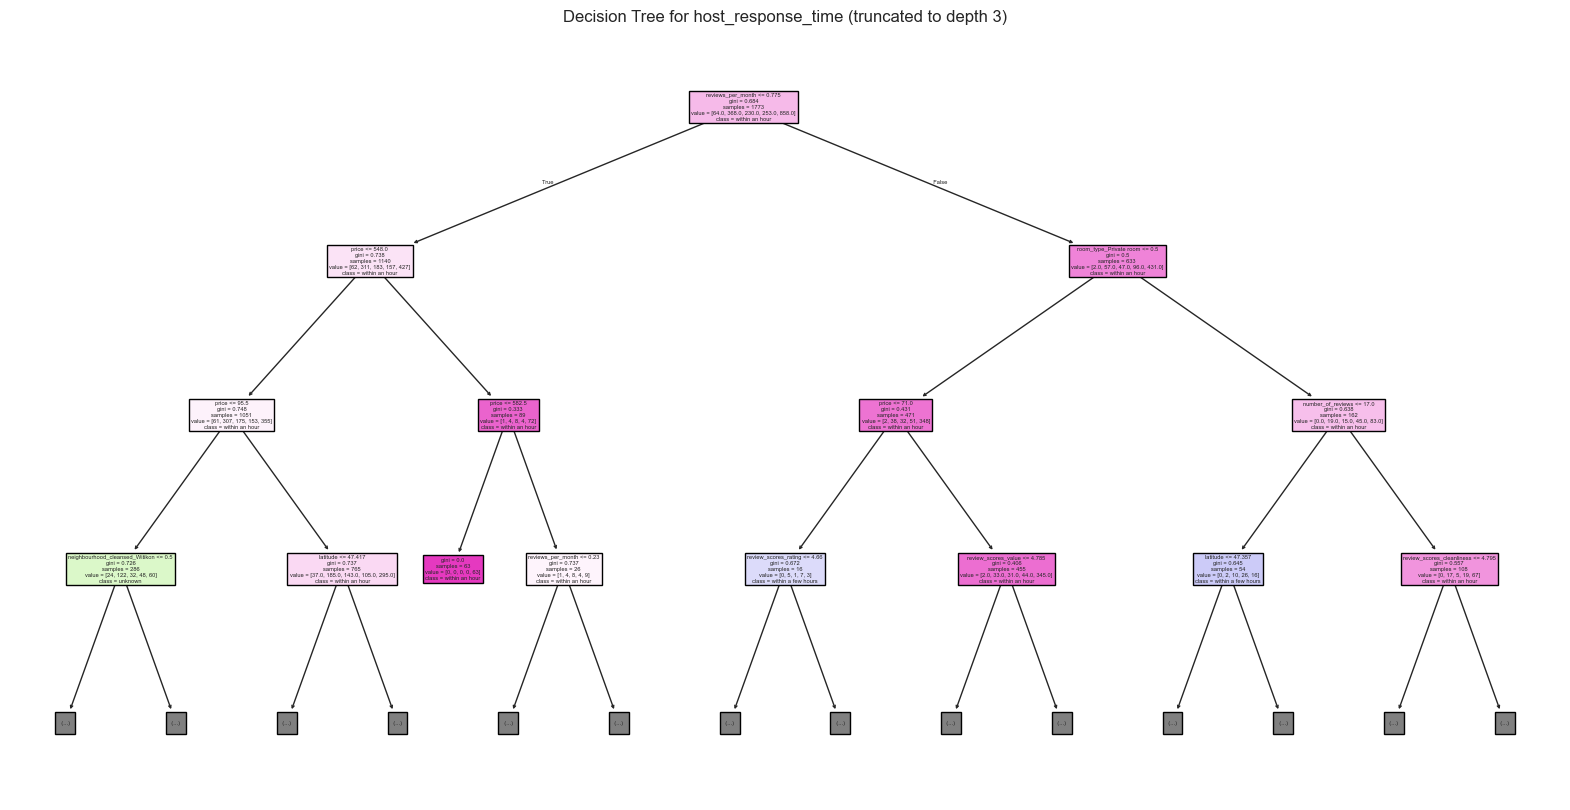

In [49]:
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=X_tree.columns,
    class_names=le_response.classes_,
    filled=True,
    max_depth=3  # just for readability
)
plt.title("Decision Tree for host_response_time (truncated to depth 3)")
plt.show()

## Tree Classification Summary
The model host responsiveness, we treated host_response_time as a multi-class target with fivecategories. ("within an hour", "within a few hours", "within a day", "a few days or more", and"unknown"). We used a set of listing and review characteristics as predictors, and a few key
categorical features encoded as dummies. After spliting the test sets, a grid search with cross-validation was carried out to tune the tree's complexity, varying max_depth and min_samples_leaf.This process was aimed to avoid both overfitting and underfitting.

The final decision tree achieved about 53% accuracy on the test set, which is only modestly better than a naive strategy that always predicts the majority class ("within an hour", roughly 48% of the data). The confusion matrix and classification report show that the model 
is heavily biased toward this majority class and perform poorly on rarer categories. While the tree captures some relationships
between listing/review features and very fast responses, it has difficulty distinguishing among the slower response categories, 
likely due to class imbalance and overlapping feature patterns. This suggests that additional features (more detailed host-level information) or different methods (class-weighted models) might be needed to get a better predictions across all response-time categories.

# Part 4. Clustering

In [ ]:
import os
os.environ["JOBLIB_TEMP_FOLDER"] = "./joblib_temp"
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

df_cluster = df_clean.copy()

df_cluster = df_cluster[
    (df_cluster['price'].notna()) & 
    (df_cluster['price'] > 0) & 
    (df_cluster['accommodates'] > 0)
].copy()

df_cluster['price_per_guest'] = df_cluster['price'] / df_cluster['accommodates']

df_cluster['bathrooms_per_bedroom'] = df_cluster['bathrooms_clean'] / df_cluster['bedrooms'].replace(0, np.nan)
df_cluster['bathrooms_per_bedroom'] = df_cluster['bathrooms_per_bedroom'].fillna(
    df_cluster['bathrooms_per_bedroom'].median()
)

review_cols_for_quality = [
    'review_scores_rating', 
    'review_scores_location', 
    'review_scores_value'
]
df_cluster['review_quality'] = df_cluster[review_cols_for_quality].mean(axis=1)

df_cluster['log_reviews'] = np.log1p(df_cluster['number_of_reviews'])


cluster_features = [
    'price',
    'price_per_guest',
    'accommodates',
    'bedrooms',
    'bathrooms_clean',
    'bathrooms_per_bedroom',
    'review_quality',
    'log_reviews',
    'minimum_nights',
    'availability_365'
]

for col in cluster_features:
    df_cluster[col] = df_cluster[col].fillna(df_cluster[col].median())

for col in cluster_features:
    upper = df_cluster[col].quantile(0.99)
    df_cluster[col] = df_cluster[col].clip(upper=upper)

scaler = StandardScaler()
X_cluster = df_cluster[cluster_features].values
X_cluster_scaled = scaler.fit_transform(X_cluster)

print("Clustering feature matrix shape:", X_cluster_scaled.shape)
print("Features used:", cluster_features)

kmeans = KMeans(
    n_clusters=3, 
    random_state=699,
    n_init=20
)

df_cluster["cluster"] = kmeans.fit_predict(X_cluster_scaled)


cluster_profiles = df_cluster.groupby('cluster').agg({
    'price': 'mean',
    'accommodates': 'mean',
    'review_quality': 'mean',
    'bathrooms_clean': 'mean'
}).round(2)

print("Cluster Profiles (to determine names):")
print(cluster_profiles)

cluster_names = {
    0: "Mid-Range Standard", 
    1: "Budget Solo/Couple",       
    2: "High-End Luxury"           
}

cluster_descriptions = {
    0: "Typical mid-priced apartments with moderate size. Target families and tourists.",
    1: "Compact, budget-friendly rentals for solo travelers and couples.",
    2: "Premium luxury properties with excellent reviews and high-end amenities."
}

df_cluster['cluster_name'] = df_cluster['cluster'].map(cluster_names)
df_cluster['cluster_description'] = df_cluster['cluster'].map(cluster_descriptions)
print("Cluster label counts:\n", df_cluster["cluster"].value_counts())

for cluster_id in sorted(cluster_names.keys()):
    count = (df_cluster['cluster'] == cluster_id).sum()
    pct = count / len(df_cluster) * 100
    print(f"\nCluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"  Size: {count} properties ({pct:.1f}%)")
    print(f"  Description: {cluster_descriptions[cluster_id]}")
    
for cluster_id in sorted(df_cluster['cluster'].unique()):
    cluster_data = df_cluster[df_cluster['cluster'] == cluster_id]
    count = len(cluster_data)
    pct = count / len(df_cluster) * 100
    
    print(f"\nCluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"  Market Share: {count} properties ({pct:.1f}%)")
    print(f"  Avg Price: CHF {cluster_data['price'].mean():.0f}")
    print(f"  Avg Capacity: {cluster_data['accommodates'].mean():.1f} guests")
    print(f"  Avg Review: {cluster_data['review_quality'].mean():.2f}/5.0")
    print(f"  Description: {cluster_descriptions[cluster_id]}")

Clustering feature matrix shape: (2534, 10)
Features used: ['price', 'price_per_guest', 'accommodates', 'bedrooms', 'bathrooms_clean', 'bathrooms_per_bedroom', 'review_quality', 'log_reviews', 'minimum_nights', 'availability_365']
Cluster Profiles (to determine names):
          price  accommodates  review_quality  bathrooms_clean
cluster                                                       
0        245.87          4.76            4.74             1.40
1        122.77          2.17            4.75             1.10
2        583.84          2.96            4.72             1.17
Cluster label counts:
 cluster
1    1867
0     486
2     181
Name: count, dtype: int64

Cluster 0: Mid-Range Standard
  Size: 486 properties (19.2%)
  Description: Typical mid-priced apartments with moderate size. Target families and tourists.

Cluster 1: Budget Solo/Couple
  Size: 1867 properties (73.7%)
  Description: Compact, budget-friendly rentals for solo travelers and couples.

Cluster 2: High-End Luxury


### Variables

**Cluster Features:**
1. Price
2. Price per Guest
3. Accomodates
4. Bedrooms
5. Bathrooms Clean
6. Bathrooms per Bedroom
7. Review Quality
8. Log Reviews
9. Minimum Nights
10. Availability (365)

- When looking at the variables that could be chosen for the model building, it was important to identify information that would be important when looking at why there would be more property value and what would indicate specific things about these properties. 

**Additional Features**
- Some of these features were also chosen because when they are put together, they can indicate even more about the property itself. When these are combined it shines more light on the overall prospects of the property and the values.

k=2: silhouette score = 0.306
k=3: silhouette score = 0.320
k=4: silhouette score = 0.273
k=5: silhouette score = 0.177
k=6: silhouette score = 0.187
k=7: silhouette score = 0.199
k=8: silhouette score = 0.208


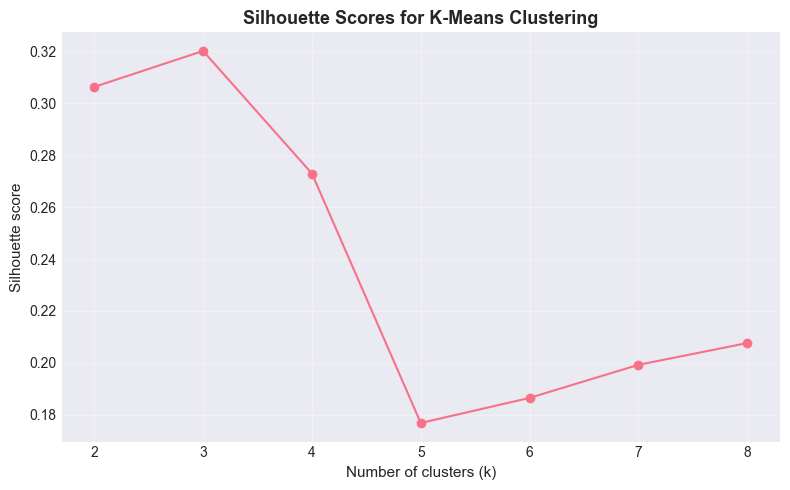

In [ ]:
silhouette_scores = {}

k_values = range(2, 9)
for k in k_values:
    kmeans_tmp = KMeans(
        n_clusters=k, 
        random_state=699,
        n_init=20
    )
    labels_tmp = kmeans_tmp.fit_predict(X_cluster_scaled)
    sil = silhouette_score(X_cluster_scaled, labels_tmp)
    silhouette_scores[k] = sil
    print(f"k={k}: silhouette score = {sil:.3f}")

plt.figure(figsize=(8, 5))
plt.plot(list(silhouette_scores.keys()),
         list(silhouette_scores.values()),
         marker='o')
plt.xlabel('Number of clusters (k)', fontsize=11)
plt.ylabel('Silhouette score', fontsize=11)
plt.title('Silhouette Scores for K-Means Clustering', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/kmeans_silhouette_scores.png', dpi=300, bbox_inches='tight')
plt.show()


## Part 4.1 K-Cluster

**How we chose the number of clusters**
- When looking at the best K cluster, based on the **silhouette score** the best cluster would be cluster 3 which has the highest silhouette score, which indicates that there is the strongest mathematical justification. 
- This can also be noted in the graphic where **cluster (k) = 3 has the highest silhouette score**, indicating clear and interpretable market data with proper separation seen in other clusters.

Explained variance ratio by PC1 and PC2: [0.24816016 0.18186709]


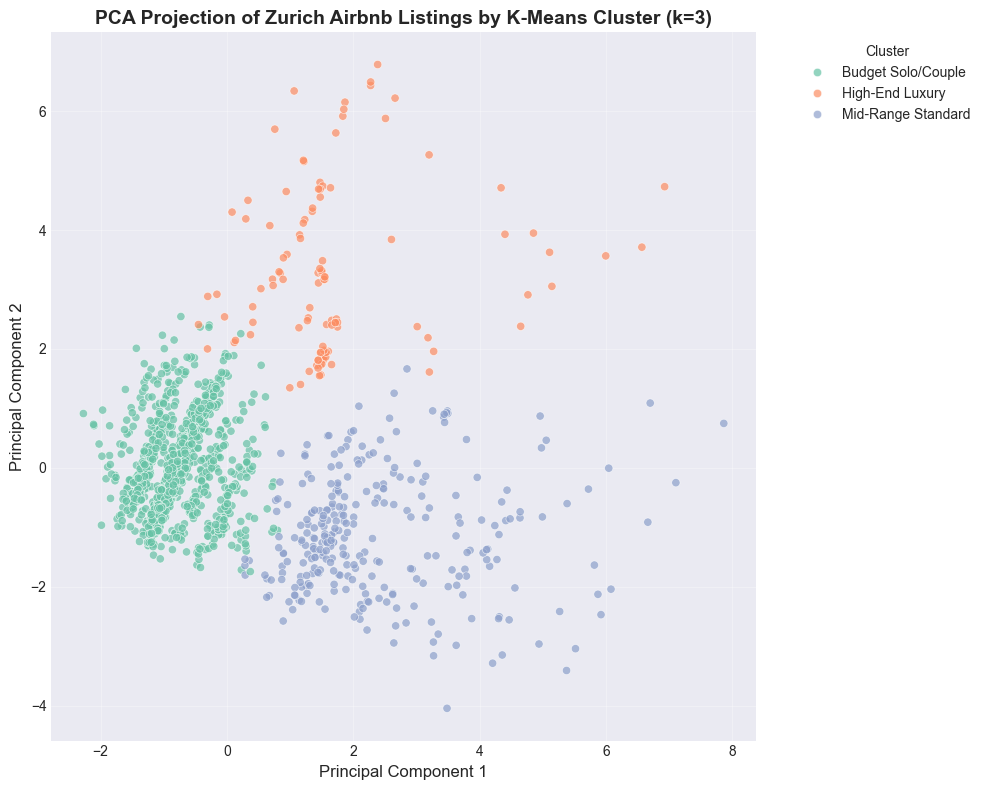

In [63]:
pca = PCA(n_components=2, random_state=699)
components = pca.fit_transform(X_cluster_scaled)

df_cluster['PC1'] = components[:, 0]
df_cluster['PC2'] = components[:, 1]

print("Explained variance ratio by PC1 and PC2:",
      pca.explained_variance_ratio_)

plt.figure(figsize=(10, 8))

plot_sample = df_cluster.sample(
    min(1500, len(df_cluster)), 
    random_state=42
)

sns.scatterplot(
    data=plot_sample,
    x="PC1", y="PC2",
    hue="cluster_name",
    palette="Set2",
    alpha=0.7
)

plt.title("PCA Projection of Zurich Airbnb Listings by K-Means Cluster (k=3)", 
          fontsize=14, fontweight='bold')
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/kmeans_pca_clusters_k3.png', dpi=300, bbox_inches='tight')
plt.show()


## PCA (Principal Component Analysis)

**PCA Description**
- The PCA visualizes our Zurich Airbnb listings in two-dimensional PCA spaces, with each point representing one rental unit and each color representing one of the three clusters that were identified above by k-means. This was the optimal number of clusters that was mentioned above and identified as the best with the silhouette score. When looking at the listings they are broken down into the 3 clusters.

    - These clusters separate cleanly, and there can be three distinct clouds, that are identified by out feature engineering to include price per guest, size, review quality, availability, ext as identified above.

    - PC1 separates listings by size/price, so looking at the left is smaller and cheaper properties, and the right is larger and more expensive.

    - PC2 separates listings by quality and booking dynamics, so the low is average quality and demand and high is premium units with strong reviews or high turnover.

1. **Cluster 2 (Blue)** 
    - Name: High-End Cluster
- High-Quality, High-Capacity Listings
- This can be noted as the high points on PC1 and PC2.
- There is a large vertical spread compared to the other clusters.
- Blue properties differ from the other two clusters.

**Cluster 2 Description:** Cluster 2 listings tend to be more expensive, larger (have bigger accommodation and or bedrooms), have better review quality, and have higher booking activity. These could be premium or upscale units and possibly be entire apartments for families or corporate travelers, or groups. Larger properties may have a larger price and be more expensive and will likely carry bigger experiences that could alter the likelihood that they have a good review. This is our premium or upscale units.

2. **Cluster 1 (Orange)** 
    - Name: Budget Cluster
- These are the Compact, Lower-Priced Rentals
- This cluster sits far left on PC1 (This indicates that there are smaller, cheaper, and lower capacity properties)
- Moderate PC2 values
- Forms a very dense and tight cluster, this shows that these listings are very similar to each other.

**Cluster 1 Description:** These listings tend to be lower prices, and smaller, have lower accommodations and bedrooms than Cluster 2, often targeting individuals such as solo travelers or couples, and will be more uniform in their features. This can be seen in their tight clustering with not much differentiation between them from each other. These are our budget and compact stay segments.

3. **Cluster 0 (Green)**
    - Name: Mid Range Cluster
- These are standard apartments
- This cluster dominates the right side of the graph, targeting the lower right.
- This is a moderate sized, more dispersed cluster.

**Cluster 0 Description:** These are typical, mid-priced Zurich apartments with moderate size, above average reviews, balanced price per guest, but are not luxury like Cluster 2, but not quite budget like Cluster 1. This is the middle of the market for Zurich. This is the most common Airbnb inventory in major cities.

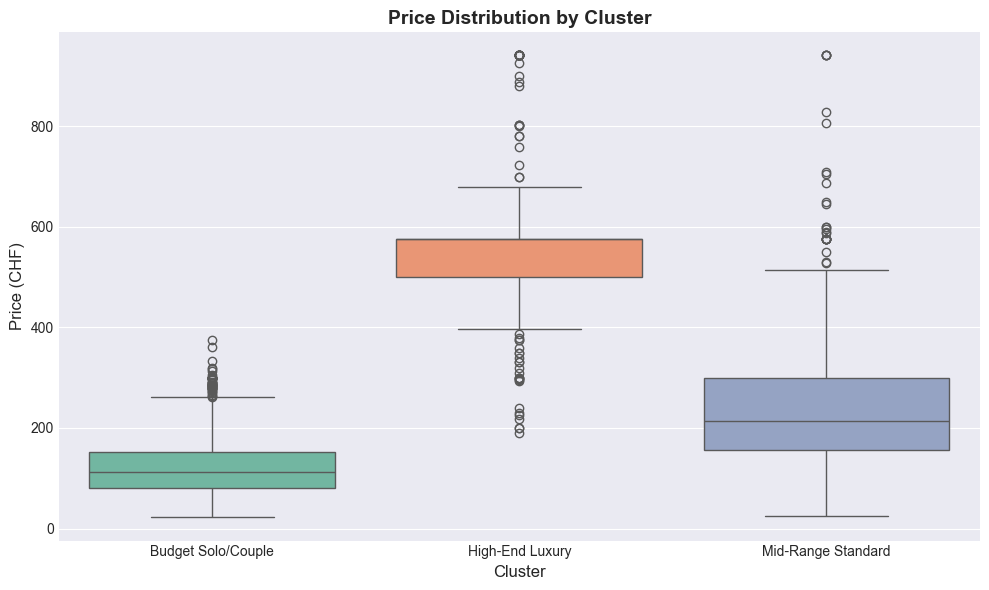

In [61]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_cluster, 
    x='cluster_name', 
    y='price', 
    palette='Set2'
)
plt.title('Price Distribution by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Price (CHF)', fontsize=12)
plt.tight_layout()
plt.savefig('output/cluster_price_boxplot.png', dpi=300)
plt.show()


## Boxplot

**Boxplot Explanation**

  This boxplot shows how nightly prices differ across our three clusters. Like what we saw in our PCA analysis, our Cluster 2 is the highest priced properties. We can see that the average price for cluster 2 is around \\$550. This is called the High end cluster. The same observations can be had for cluster 1 and 0, because it's partially what fed into the data for the PCA, but delves further into the actual average price of each cluster. Our Cluster 1 "Budget" can be seen as having an average price of roughly \\$100. Our Cluster 0 "Mid Range" has an average price of roughly \\$210. This properly shows each of the clusters breaking out its distinct values within Zurich and organizes the data to represent the key features targeted.

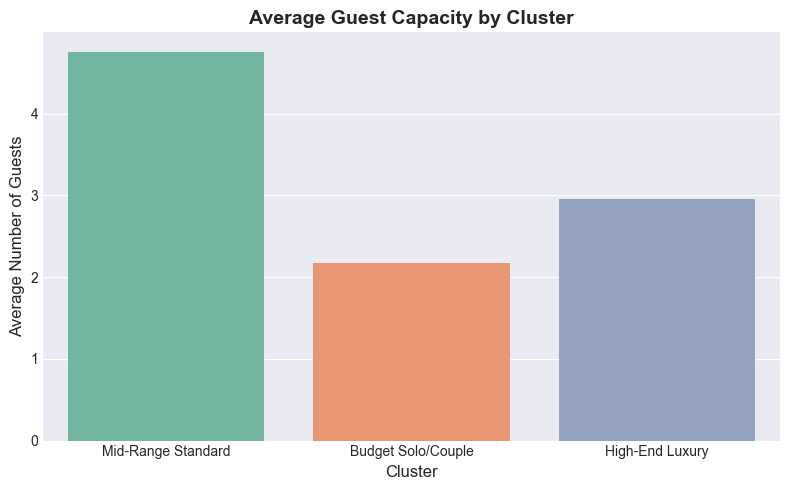

In [ ]:
df_cluster['cluster_name'] = df_cluster['cluster'].map(cluster_names)

cluster_sizes = (
    df_cluster.groupby('cluster')['accommodates']
    .mean()
    .reset_index()
)

cluster_sizes['cluster_name'] = cluster_sizes['cluster'].map(cluster_names)

plt.figure(figsize=(8,5))
sns.barplot(
    data=cluster_sizes, 
    x='cluster_name', 
    y='accommodates', 
    palette='Set2'
)
plt.title('Average Guest Capacity by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Number of Guests', fontsize=12)
plt.tight_layout()
plt.savefig('output/cluster_accommodates_barplot.png', dpi=300)
plt.show()


# Bar Chart

**Bar Chart Explanation:**

  When looking at the bar chart it compares the average number of guests each cluster can accommodate. **Budget listings (Cluster 1)** host the fewest number of people, While **Mid Range (Cluster 0)** accommodates the most people and more spacious rentals. **High end (Cluster 2)** averages around 3 guests but costs the most and is considered a luxury property and may be more compact listings. The PCA indicates that High end has limited larger properties but remains high in price for the properties that they have showing that they could be nicer in quality and not size.

# Conclusion
    
  The Airbnb dataset for Zurich required a number of data cleaning and preparation steps to be produce useful and robust results. 
We applied median imputation steps, applied regex pattern matching to extract bathroom values, replaced NaN values with empty string 
and removed rows missing price data. The various summary graphs created provided a great view into the rental property experience in 
Zurich and how various neighborhoods vary. These graphs would provide very useful information for potential investors by providing a 
real-time view in which properties and which amenties receive the most visits and command the highest fees.

  Our classification and clustering analysis results allow provide a more robust understanding of the features that are sought out 
together. Though we considered 23 features for our multi-linear analysis our model only had a 37.5% adjusted R^2 and thus could only 
explain 38% of the variability. Key findings from this analysis was that Type of Room was the main differentiator that commanded higher 
prices with hotel room type leading the higher prices. Similarly our tree classification model only had a 53% accuracy rating. In 
hindsight many features such beds/ bedrooms/accommodation could have been combined into 1 feature from the onset and other features 
such latitude and longitude could have also been removed, since these features were either redundant or not significant through out 
the analysis we carried out. Applying this manual feature selection at onset would have increased accuracy for most of the models we
created.  


## Part 5: Overall Conclusions

### Key Findings Summary

1. **Pricing Drivers (Regression)**: Property capacity and location are the 
   strongest price predictors. Each additional guest capacity increases price 
   by 18%, while premium neighborhoods command 35-44% premiums.

2. **Amenity Patterns (k-NN)**: Dishwasher presence can be predicted with 64% 
   accuracy from property characteristics, suggesting that larger/higher-quality 
   properties systematically offer more amenities.

3. **Host Behavior (Decision Tree)**: Response time is challenging to predict 
   (53% accuracy) from property features alone, indicating host behavior is 
   more personal than property-driven.

4. **Market Segmentation (Clustering)**: Three distinct market segments exist:
   - Budget (74% of market): Compact, lower-priced
   - Mid-Range (19%): Standard apartments, moderate pricing
   - High-End (7%): Luxury properties, premium pricing

### Business Implications

**For Hosts:**
- Optimize capacity to maximize revenue
- Location matters more than property size
- Premium neighborhoods justify 30-40% higher prices

**For Investors:**
- Budget segment offers volume but low margins
- High-end segment is small but highly profitable
- Mid-range represents the stable core market

### Limitations

- R² of 0.375 means 62.5% of variance remains unexplained
- Missing factors: exact street location, property photos, seasonal demand
- Text features showed weak predictive power
- Host behavioral patterns difficult to predict from property attributes

### Future Directions

- Include temporal data (seasonality, events)
- Incorporate image quality analysis
- Add neighborhood walkability scores
- Consider dynamic pricing models